In [1]:
import sys
sys.path.append("/home/bl9/gempy/")
#sys.path.append("C:/Users/Fabian/gempy/")
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

from gempy import Topology

import vtk

In [2]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,-2000,0],[ 50,50,50],
                         #path_f = "/home/bl9/gempy//input_data/Fab_TrapModel_Foliations.csv",
                         #path_i = "/home/bl9/gempy//input_data/Fab_TrapModel_Points.csv")
                         path_f = "./input_data/FabLessPoints_Foliations.csv",
                         path_i = "./input_data/FabLessPoints_Points1.csv")
geo_data.n_faults = 1

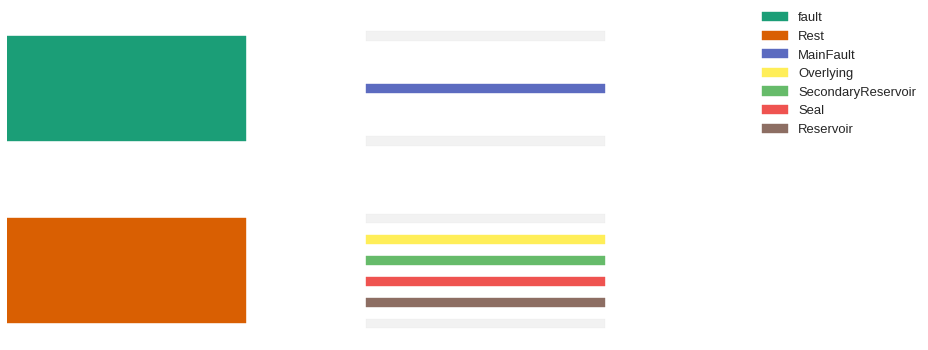

In [3]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Reservoir', 'Seal', 'SecondaryReservoir', 'Overlying')},
                       order_series = ["fault","Rest",], order_formations=['MainFault', 
                                         'Overlying', 'SecondaryReservoir', 'Seal','Reservoir',
                                         ])

In [51]:
#geo_data.set_formation_number(['MainFault','Reservoir','Seal','SecondaryReservoir','Overlying'])

In [7]:
#gp.data_to_pickle(geo_data, 'BasicFault') #saving data to pickle

In [8]:
#geo_data.interfaces.head()
#gp.get_data(geo_data)

In [ ]:
gp.plot_data(geo_data)

In [ ]:
gp.plot_data_3D(geo_data)

In [4]:
# INTERPOLATION
interp_data = gp.InterpolatorInput(geo_data, 
                                   u_grade = [3, 3],
                                   compile_theano=True)

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


In [5]:
# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

In [46]:
# CREATING SURFACES FOR LAYERS
res_surf, res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[0,1], potential_fault=fault_sol[0,1], n_formation = (interp_data.get_formation_number()['Reservoir']))
overlying_surf, overlying_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[0,1], potential_fault=fault_sol[0,1], n_formation = (interp_data.get_formation_number()['Overlying']))
sec_res_surf, sec_res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[0,1], potential_fault=fault_sol[0,1], n_formation = (interp_data.get_formation_number()['SecondaryReservoir']))
seal_surf, seal_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[0,1], potential_fault=fault_sol[0,1], n_formation = (interp_data.get_formation_number()['Seal']))

In [11]:
print(res_surf.shape, seal_surf.shape, sec_res_surf.shape, overlying_surf.shape)

(4290, 3) (4252, 3) (4070, 3) (4426, 3)


In [111]:
#geo_data.get_formation_number().keys()

In [112]:
#geo_data.get_formations()

In [10]:
geo_data.get_formation_number()

{'DefaultBasement': 0,
 'MainFault': 1,
 'Overlying': 2,
 'Reservoir': 5,
 'Seal': 4,
 'SecondaryReservoir': 3}

In [47]:
gp.plot_surfaces_3D(geo_data, [overlying_surf, sec_res_surf, seal_surf, res_surf], 
                    [overlying_surf_simp, sec_res_surf_simp, seal_surf_simp, res_surf_simp], plot_data=True)

In [186]:
#sys.path.append("/home/bl9/gempy/gempy/")
#
#import Visualization 
#importlib.reload(Visualization)

<module 'Visualization' from '/home/bl9/gempy/gempy/Visualization.py'>

In [189]:
#w = Visualization.vtkVisualization(interp_data.geo_data_res, real_time=True )
#w.set_surfaces([overlying_surf, sec_res_surf, seal_surf, res_surf], 
#               [overlying_surf_simp, sec_res_surf_simp, seal_surf_simp, res_surf_simp],
#               #formations_names_l, formation_numbers_l,
#                )
#w.interp_data  = interp_data
#if True:
#    w.set_interfaces()
#    w.set_foliations()
#w.render_model()

In [79]:
gp.plot_surfaces_3D(geo_data, [res_surf], [res_surf_simp])

In [12]:
interp_data.get_formation_number()

{'DefaultBasement': 0,
 'MainFault': 1,
 'Overlying': 2,
 'Reservoir': 5,
 'Seal': 4,
 'SecondaryReservoir': 3}

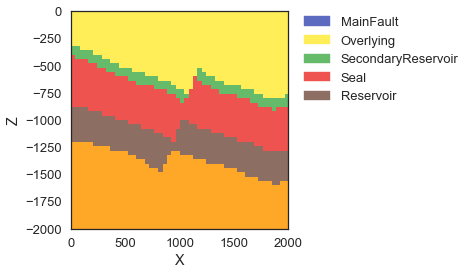

In [6]:
#%matplotlib notebook
%matplotlib inline
gp.plot_section(geo_data, lith_sol[0,0], 25) #plot_data=True)

In [6]:
resolution = 50
model_size = 2000
scale_factor = (model_size/resolution) #original grid in [m]/grid resolution --> what if model not cubic?

In [7]:
# SPILL AND LEAK POINT FUNCTIONS

# Finding the spill point
def spill_point(res_surface):
    mini = argrelextrema(res_surface[:,2], np.less, order=10)
    minima = np.array(list(zip(np.take(res_surface[:,1], mini[0]), np.take(res_surface[:,0], mini[0]), np.take(res_surface[:,2], mini[0]))))
    fault_thresh = minima[:,1] > 700 #taking only relevant side by setting a threshold visually estimated, best: 20
    spill_min_line = minima[fault_thresh]
    spill_pos = np.array(np.argmax(spill_min_line[:,2]))
    spill_z = np.take(spill_min_line[:,2], spill_pos)
    spill_p = np.array([np.take(spill_min_line[:,1], spill_pos), np.take(spill_min_line[:,0],
                                spill_pos), np.take(spill_min_line[:,2], spill_pos)])
    
    # Horizontal plane defined by z-pos of spill
    if True:
        spill_bottom = np.ones_like(res_surface)
        spill_bottom[:,0] = res_surface[:,0]
        spill_bottom[:,1] = res_surface[:,1]
        spill_bottom[:,2] = spill_z    
    
    return spill_z, spill_p, spill_min_line, spill_bottom

# Finding the leak point ( critically inefficient method! takes 10s!)
def leak_point(res_surface):
    counter = 0
    # Creating empty lists and arrays to save values
    xvals = []
    yvals = []
    zvals = []
    leak_min = np.empty((0,3), dtype=int)
    #leak_min = np.empty([3,], dtype=int)
    
    for i in np.unique(res_surface[:,1]):
        
    #while counter < model_size:
        #print(counter)
        for e in res_surface:
            # Looking at a slice along y-axis for y = e[1] = counter, 
            # and appending x,y,z-values into lists
            # This is a way of RESORTING the array as needed
            #if int(e[1]) == counter:
            if e[1] == i:
                xvals.append(e[0])
                yvals.append(e[1])
                zvals.append(e[2])
            
        # Saving x,y,z-values as lists/arrays      
        zvals = np.array(zvals)
        yvals = np.array(yvals)
        xvals = np.array(xvals)

        # Looking fore minima positions in z-array
        min_pos = argrelextrema(zvals, np.less, order=10)
        
        # Saving x,y,z-positions of minima
        ypos = yvals[min_pos]
        xpos = xvals[min_pos]
        mins = zvals[min_pos]
        
        # Condition: Check if any minimum was found and if any data is given at y = counter
        # If no minimum found, restart loop at next iteration
        # This way, we can work with the data that coesn't cover every 1 step along the model
        # (such as the surface vertices)
        if len(mins) == 0:
            counter += 1
            #lists have to be emptied again
            xvals = []
            yvals = []
            zvals = []
            continue
        
        #np.append(leak_min, mins) -----> what did I use this for?
        
        # Create and array element to save coordinates of minima
        mins_pos = np.array(list(zip(xpos, ypos, mins)))
        # Save minima of slice into array of ALL minima
        leak_min = np.vstack((leak_min, mins_pos))

        # Empty lists for next iteration
        xvals = []
        yvals = []
        zvals = []
    
        counter += 1
        
    #leak_min = np.delete(leak_min, 0, 0) #what does this do???
    
    # Result of the loop above is one or SEVERAL lines of minima ("leak lines")
    # only want to look at the line bordering the fault surface
    # need for a general function/method to limit to only that line!
    # For now: Taking only relevant side by setting a threshold that is visually estimated
    near_fault_thresh = leak_min[:,0] < 1500
    leak_line = leak_min[near_fault_thresh]
    
    # The highest point of the leak line is the leak point!
    leak_pos = np.array(np.argmax(leak_line[:,2]))
    leak_z = np.take(leak_line[:,2], leak_pos)

    # Full coordinates of the leak point as array element
    leak_p = np.array([np.take(leak_line[:,1], leak_pos), np.take(leak_line[:,0], leak_pos), np.take(leak_line[:,2], leak_pos)])
    
    # Creating a horizontal plane defined by the leak point z-position, in shape of res_surface
    leak_bottom = np.ones_like(res_surface)
    leak_bottom[:,0] = res_surface[:,0]
    leak_bottom[:,1] = res_surface[:,1]
    leak_bottom[:,2] = leak_z
   
    return leak_z, leak_p, leak_line, leak_bottom

In [8]:
# MASKING FUNCTIONS

# Masking function that confines to voxels which are part fo the reservoir formation,
# in the footwall side and above the z-horizontal defined by the spill or leak point
def res_mask(lith,fault, bottom_z, formation_nr):
    mask = np.ones_like(lith)
    mask[~formation_nr] = False
    mask[fault.astype(bool)] = False
    bottom_z = bottom_z/scale_factor
    mask = mask.reshape(50,50,50)
    mask[:,:,:bottom_z] = False
    mask = mask.reshape(125000,)
    return mask

# Function that sets all voxels of lith_block which are equal (or closest to) to the spill_z
# horizontal as belonging to the overlying seal 
# (the voxels is located on the border of reservoir and seal):
def set_spill_to_seal(geo_data, lith, max_z):
    lith_spill = np.argmin(np.abs(geo_data.grid.grid[:, 2]+np.abs(max_z)))
    bol_lith_spill = geo_data.grid.grid[:, 2] == geo_data.grid.grid[:, 2][lith_spill]
    lith[bol_lith_spill] = 6
    return lith
        ### Hpw to check in here, if single spill voxel = reservoir (5)??? Need x and y pos?

# Masking that confines the volume to ONLY those reservoir traps (from res_mask)
# that are NOT connected to the borders of the model (open system)
# Traps defined as CLOSED systems
def topo_analysis(lith, fault):
    fig = plt.figure()
    traps = []
    # Padding of lith- and fault-block (creating border sections, formation number = 8)
    lith_pad = (np.pad(lith.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
    fault_pad = (np.pad(fault.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
    topo = Topology.Topology(lith_pad, fault_pad)
    #topo.draw_section(25)
    topo_block = topo.labels
    # Finding sections which are possible traps in the reservoir (formation number = 7)
    topo_keys = [int(k) for k in topo.lith_to_labels_lot["7"].keys()]
    pad_keys = [int(p) for p in topo.lith_to_labels_lot["8"].keys()]
    #over_keys = [int(o) for o in topo.lith_to_labels_lot["2"].keys()]
    #sec_res_keys = [int(sr) for sr in topo.lith_to_labels_lot["3"].keys()]
    bool_block = np.zeros_like(topo_block)
    # Check for each possible trap section, if it is connected to a border
    for tk in topo_keys:
        print('Checking Section:', tk)
        # Saving enclosed sections as traps
        if topo.check_adjacency(tk, pad_keys[0]) == False:
            print("TRAP FOUND, section:", tk)
            traps.append(tk)
    if traps == []:
        print('No trap found! =(')
    else:
        for i in traps:
            # Creating a mask from the trap sections in the label block
            top_bool = topo_block == i
            bool_block[top_bool] = True
            ### Extra check for juxtaposition with layers above seal
            #if topo.check_adjacency(i, over_keys[0]) == False and topo.check_adjacency(i, sec_res_keys[0]) == False:
            #    print('Trap sealed upwards.')
            #    top_bool = topo_block == i
            #    bool_block[top_bool] = True
            #else: 
            #    print("Juxtaposition, no trap sealing.")
    # Removing padding
    trap_mask = bool_block[1:-1,1:-1,1:-1]
    #plt.imshow(trap_mask[:,25,:].T, origin="lower")
    #plt.show()
    return trap_mask

In [9]:
# MAIN FUNCTION: Calculation of maximum fill volume in reservoir traps

def max_trap_vol(lith, fault, res_surface, fault_sealing):
    # calculate spill point
    spill_z, spill_p, spill_min_line, spill_bottom = spill_point(res_surface)
    # calculate leak point
    leak_z, leak_p, leak_line, leak_bottom = leak_point(res_surface)
    
    #PLOTTING OF SPILL, LEAK AND BOTTOM POSSIBLE HERE:
    #plot_spill(res_surface, spill_min_line, spill_p)
    #plot_leak(res_surface, leak_line, leak_p)
    #plot_trap(res_surface, bottom_surface, spill_p, leak_p)
    #PRINTING OF SPILL, LEAK:
    #print('Spill_Z:', spill_z)
    #print('Leak_Z:', leak_z)
    
    # Check for "down-to" z-horizon, maximum depth of reservoir
    # Check for fault sealing and subsequent relevance of leak point
    max_z = np.max([spill_z, leak_z])
    if fault_sealing == True:
        if max_z == spill_z:
            print("Spill point defines trap.")
            print("Fault is sealing. Down to spill.")
            bottom_surface = spill_bottom
        else:
            print("Fault leak point above spill point.")
            max_z = spill_z
            print("...but fault sealing. Down to spill.")
            bottom_surface = spill_bottom
    else:
        if max_z == spill_z:
            print("Spill point defines trap.")
            print("Fault is pathway. Down to spill.")
            bottom_surface = spill_bottom
        else:
            print("Fault leak point above spill point.")
            print("Cross-fault leakage. Down to leak.")
            bottom_surface = leak_bottom      
    
    #print('Max_Z:', max_z)
    
    res_nr = lith == 5 #interp_data.get_formation_number()['Reservoir']
    pre_trap_mask = res_mask(lith, fault, max_z, res_nr)
          
    # volume cells for counting
    vol_cells = 0      
    
    pre_trap_mask_bool = (pre_trap_mask == True)
    # Check if there is anaything in the reservoir mask at all
    if np.count_nonzero(pre_trap_mask_bool) == 0:
        print("No res_formation above max_z!")
        return 0, lith, bottom_surface, pre_trap_mask
    else:
        lith[pre_trap_mask_bool] = 7                           # setting reservoir above bottom on footwall side 
                                                            # (incl. outside trap) to formation value = 7  
        if max_z == spill_z:
            lith = set_spill_to_seal(geo_data, lith, max_z)
        
        #test = lith.reshape(125000)                       
        #for i in range(len(test)):                         #to test pre-trap-masking volume
        #    if test[i] == 7:
        #        vol_cells +=1
        #res_vol = ((scale_factor)**3) * vol_cells 
        #print("VOLUME INCLUDING OUTSIDE TRAP:" ,res_vol)
        
        final_trap_mask = topo_analysis(lith, fault)
        lith[final_trap_mask] = 9                         # setting final trap to formation value = 9
        vol_cells = np.count_nonzero(final_trap_mask)
        
        #calulate volume from cells
        trap_vol = ((scale_factor)**3) * vol_cells 
        
        #return the maximum reservoir volume
        return trap_vol, lith, bottom_surface, final_trap_mask

In [10]:
# PLOTTING FUNCTIONS: Spill and leak point visualization

def plot_spill(res_surface, spill_min_line, spill_p):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
    ax.scatter(-spill_min_line[:,0], -spill_min_line[:,1], spill_min_line[:,2], c='r', s = 50)
    ax.scatter(-spill_p[1], -spill_p[0], spill_p[2], c='yellow', s = 200)
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()

def plot_leak(res_surface, leak_line, leak_p):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
    ax.scatter(-leak_line[:,1], -leak_line[:,0], leak_line[:,2], c='r', s = 50)
    ax.scatter(-leak_p[1], -leak_p[0], leak_p[2], c='green', s = 200)
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()
    
def plot_trap(res_surface, bottom_surface, spill_p, leak_p):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(-bottom_surface[:,1], -bottom_surface[:,0], bottom_surface[:,2], c="r", alpha = 0.05)
    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
    ax.scatter(-spill_p[1], -spill_p[0], spill_p[2], c='yellow', s = 1000)
    ax.scatter(-leak_p[1], -leak_p[0], leak_p[2], c='green', s = 1000)

    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

In [11]:
sec_res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir']['Z']
seal_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Seal']['Z']
res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Reservoir']['Z']
over_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Overlying']['Z']

res_len = len(interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Reservoir']['Z'])

In [25]:
rescale_f = interp_data.rescaling_factor

# SETTING Z-UNCERTAINTIES FOR EACH LAYER TOP

#z_unc_over = pymc.Normal('z_unc_over_bot', 0, 1./0.0001)
#z_unc_seal_top = pymc.Normal('z_unc_seal_top', 0, 1./0.0003)
#z_unc_res_top = pymc.Normal('z_unc_res_top', 0, 1./0.0005)
#z_unc_res_bot = pymc.Normal('z_unc_res_bot', 0, 1./0.0008)

std_over = 10
std_seal_top = 20
std_res_top = 40
std_res_bot = 60

z_unc_over = pymc.Normal('z_unc_over_bot', 0, 1./np.square(std_over/rescale_f))
z_unc_seal_top = pymc.Normal('z_unc_seal_top', 0, 1./np.square(std_seal_top/rescale_f))
z_unc_res_top = pymc.Normal('z_unc_res_top', 0, 1./np.square(std_res_top/rescale_f))
z_unc_res_bot = pymc.Normal('z_unc_res_bot', 0, 1./np.square(std_res_bot/rescale_f))

#z_unc_over = 0
#z_unc_seal_top = 0
#z_unc_res_top = 
#z_unc_res_bot = 0

# FAULT SEALING UNCERTAINTY (True = fault sealing)
fault_sealing = pymc.Bernoulli('fault_sealing_unc',p=.5)

In [26]:
# Boolean conditions to find data points for each formation
res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'

Z-Variations top to bottom: -0.006717346197583321 0.001842527328664589 -0.005073031668478268 -0.025881895975787748


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:57: UserWarning: Boolean Serie

Spill point defines trap.
Fault is pathway. Down to spill.


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


Checking Section: 17
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Maximum reservoir volume: 20096000.0 m³


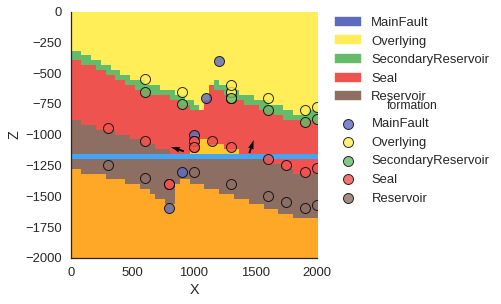

In [27]:
# MODLE FUNCTIONS 

# Updating of interp_data points with new z-values resulting from z-positional uncertainty
@pymc.deterministic
def interp_unc(value=0, z_unc_over = z_unc_over, z_unc_seal_top=z_unc_seal_top, 
                  z_unc_res_top = z_unc_res_top, z_unc_res_bot = z_unc_res_bot):
    new_z_over = over_z + z_unc_over
    new_z_sec_res = sec_res_z + z_unc_seal_top
    new_z_res_top = seal_z + z_unc_res_top
    new_z_res = res_z + z_unc_res_bot    
    print('Z-Variations top to bottom:', z_unc_over, z_unc_seal_top, z_unc_res_top, z_unc_res_bot)
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Overlying'] = new_z_over
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'] = new_z_sec_res
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Seal'] = new_z_res_top
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'] = new_z_res
    return interp_data

# Calculating formation thickness based on z-difference between a bottom and top point on the footwall (fw)

# This is done using interp_data, where X,Y and Z-values are rescaled according to the rescaling_factor.
# Value[1] of extent_rescaled equals the maximum extent of model (here: 2000).
# So if we want to find the rescaled X-position 1600, we simply calculated 2000-400 rescaled (see fw_x_cond)
# Y_mid defines that we are looking at a central position (in y-direction) in the model.
# The difference in z between two points has to be rescaled to the original scale again.

# Reservoir thickness
@pymc.deterministic
def res_th(interp_data=interp_unc):
    rescale_f = interp_data.rescaling_factor
    fw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (400/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x_cond]
    points_fw = points_fw[y_mid]   
    fw_rb_z = points_fw[res_bot_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[seal_bot_cond]['Z'].values*rescale_f
    return np.abs(fw_sb_z-fw_rb_z)

#Seal thickness
@pymc.deterministic
def seal_th(interp_data=interp_unc):
    rescale_f = interp_data.rescaling_factor
    fw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (400/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x_cond]
    points_fw = points_fw[y_mid]   
    fw_r2b_z = points_fw[sec_res_bot_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[seal_bot_cond]['Z'].values*rescale_f
    return np.abs(fw_r2b_z-fw_sb_z)

# Secondary reservoir thickness
@pymc.deterministic
def sec_res_th(interp_data=interp_unc):
    rescale_f = interp_data.rescaling_factor
    fw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (400/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x_cond]
    points_fw = points_fw[y_mid]   
    fw_r2b_z = points_fw[sec_res_bot_cond]['Z'].values*rescale_f
    fw_ob_z = points_fw[over_bot_cond]['Z'].values*rescale_f
    return np.abs(fw_ob_z-fw_r2b_z)

# Volumetric calculation 
@pymc.deterministic
def structural_model(interp_data=interp_unc, fault_sealing=fault_sealing):
    lith_sol, fault_sol = gp.compute_model(interp_data)
    lith_block = lith_sol[0,0]
    fault_block = fault_sol[0,0]  
    seal_surf, seal_surf_simp = gp.get_surfaces(
                                          interp_data = interp_data, potential_lith=lith_sol[0,1], 
        potential_fault=fault_sol[0,1], n_formation = interp_data.get_formation_number()['Seal'])
    max_vol, lith_sol[0,0], bottom, trap = max_trap_vol(lith_block, fault_block, seal_surf, fault_sealing)
    print("Maximum reservoir volume: %s m³" % max_vol)
    gp.plot_section(geo_data, lith_sol[0,0], 25, plot_data =1)
    return lith_sol, fault_sol, max_vol

In [28]:
iterations = 100

In [29]:
model = pymc.Model([interp_unc, z_unc_res_top, z_unc_res_bot, z_unc_seal_top, z_unc_over, fault_sealing, structural_model, res_th, seal_th, sec_res_th])

Z-Variations top to bottom: 0.0026503481455707667 0.001314175323345853 -0.002933730746829926 0.0016948403559606511


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Spill point defines trap.
Fault is pathway. Down to spill.


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


Checking Section: 17
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Maximum reservoir volume: 22912000.0 m³
 [                  2%                  ] 2 of 100 complete in 8.1 sec

/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Z-Variations top to bottom: -0.002555450964137328 0.011067818725918601 0.01639721957719706 0.023501980495933154
Fault leak point above spill point.
...but fault sealing. Down to spill.
Checking Section: 20
Checking Section: 19
TRAP FOUND, section: 19
Checking Section: 17
Checking Section: 12
TRAP FOUND, section: 12
Maximum reservoir volume: 57536000.0 m³
 [-                 3%                  ] 3 of 100 complete in 17.2 secZ-Variations top to bottom: -0.00299390107707137 0.004222879934454268 0.00853551507844816 -0.003167777309018036
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-                 4%                  ] 4 of 100 complete in 25.1 secZ-Variations top to bottom: -0.004625205867671893 -0.005877156786948681 0.007206898634822278 0.007362560612062522
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-          

/home/bl9/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 13
Maximum reservoir volume: 14336000.0 m³
 [----             12%                  ] 12 of 100 complete in 88.1 secZ-Variations top to bottom: 0.0011864684817746354 0.002792857708181669 -0.0013634869369729976 -0.005242421466438935
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [----             13%                  ] 13 of 100 complete in 95.9 secZ-Variations top to bottom: 0.0015999373927879754 -0.00375057271038223 -0.005844146973230809 0.006637685814960412
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 17
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Maximum reservoir volume: 18944000.0 m³
 [-----            14%                  ] 14 of 100 complete in 105.2 secZ-Variations top to bottom: 0.0031420768043781285 0.011496663397035627 -0.0036984512957782744 0.0217799632713

Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 17
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Maximum reservoir volume: 17728000.0 m³
 [-------------    35%                  ] 35 of 100 complete in 270.7 secZ-Variations top to bottom: 0.00028319605885646407 0.0021606221751666777 0.003562868698352162 -0.026606997419256123
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 17
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Maximum reservoir volume: 17024000.0 m³
 [-------------    36%                  ] 36 of 100 complete in 278.6 secZ-Variations top to bottom: 0.001983609034435222 0.00760217410372569 -0.002317084412389043 -0.0006010428950078485
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [--------------   37%                  ] 37 of 100 complete in 286.5 secZ-Variations top to bottom: 0.007747526414103627

 [-----------------58%--                ] 58 of 100 complete in 457.7 secZ-Variations top to bottom: 0.00032530187453207594 0.005318011718574326 -0.011107702111755897 -0.01198370767493436
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------59%--                ] 59 of 100 complete in 465.7 secZ-Variations top to bottom: -0.0010164820738427993 -0.004511426183070905 0.006728422815035469 0.03146537073537178
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 18
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 15
Maximum reservoir volume: 20480000.0 m³
 [-----------------60%--                ] 60 of 100 complete in 473.7 secZ-Variations top to bottom: -0.0024552069075765683 -0.002865355000848271 0.0021627495797266008 0.017479315015383794
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir vol

Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 18
TRAP FOUND, section: 18
Checking Section: 16
Checking Section: 15
Maximum reservoir volume: 19008000.0 m³
 [-----------------82%-----------       ] 82 of 100 complete in 649.4 secZ-Variations top to bottom: 0.0031604380710106893 -0.00653141932012069 -0.004044608082033752 -0.0043472919172340705
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 17
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Maximum reservoir volume: 20864000.0 m³
 [-----------------83%-----------       ] 83 of 100 complete in 657.2 secZ-Variations top to bottom: -0.003104917515693653 0.007089349624750327 -0.012595158404793604 0.008407768264381138
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 17
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 12
TRAP FOUND, section: 12
Maximum reservoir volume: 11712000.0 m³
 [-----------------84

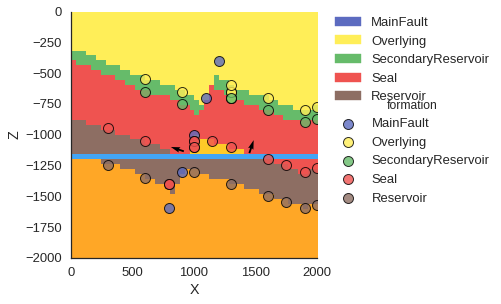

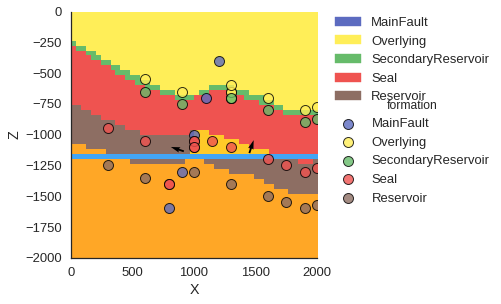

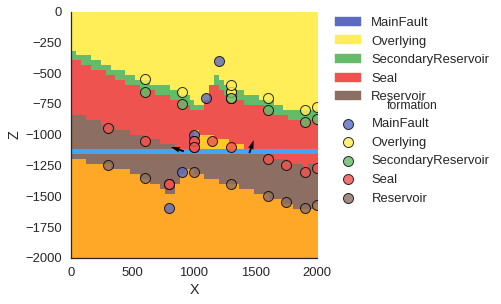

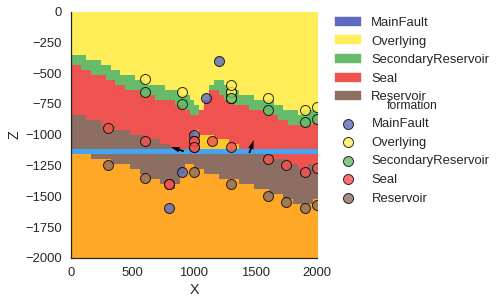

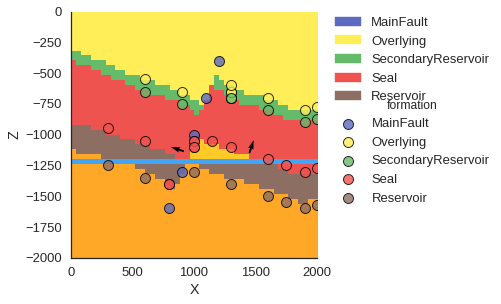

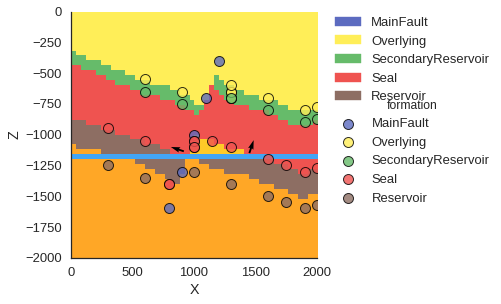

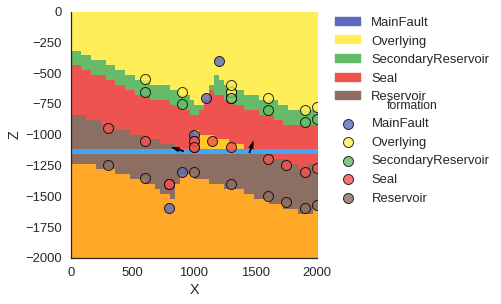

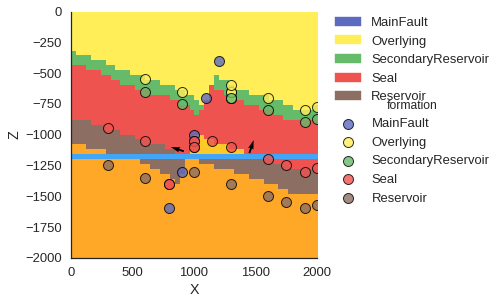

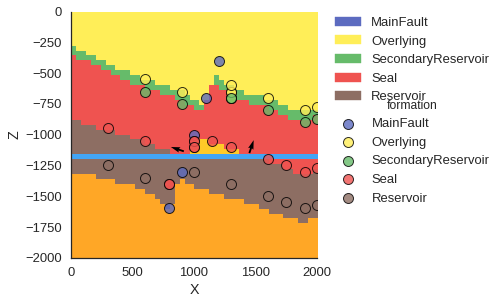

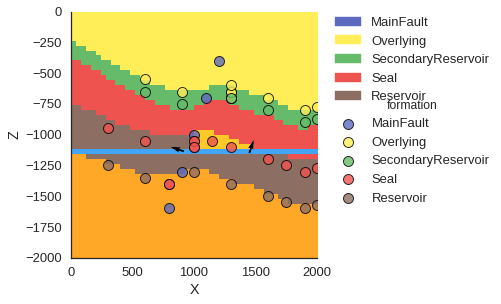

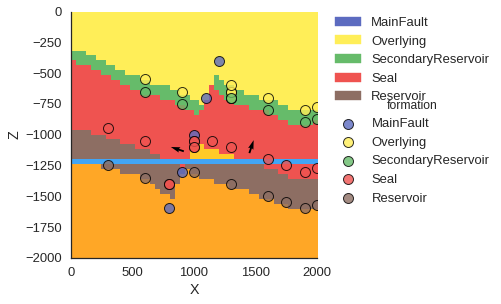

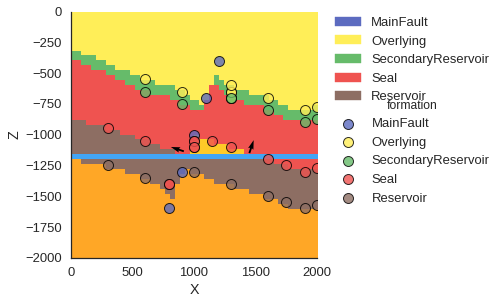

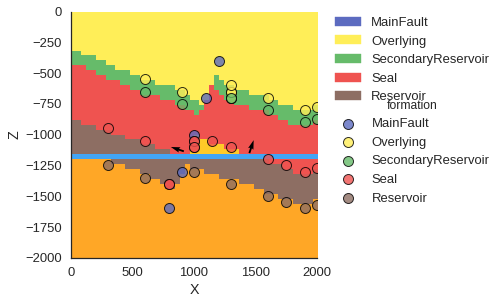

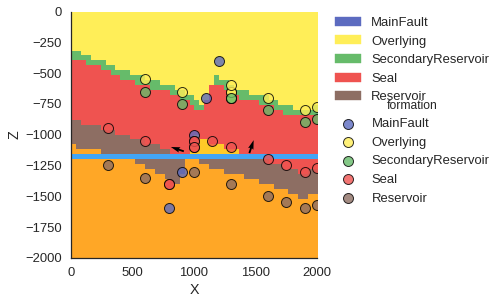

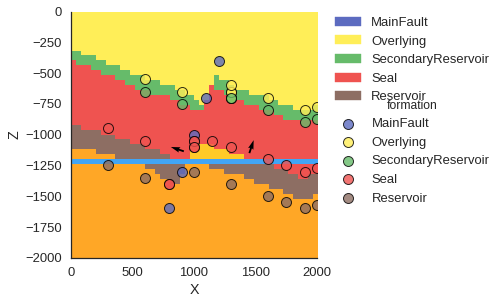

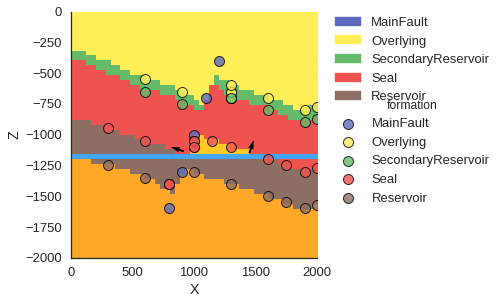

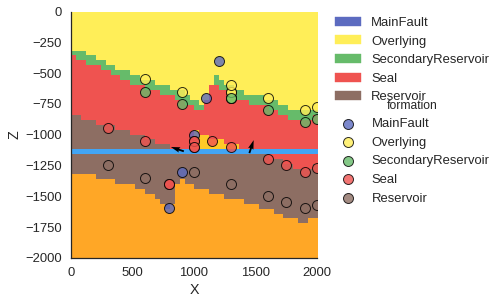

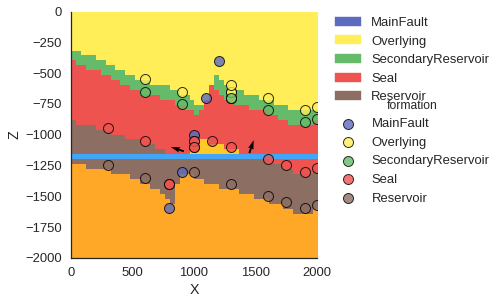

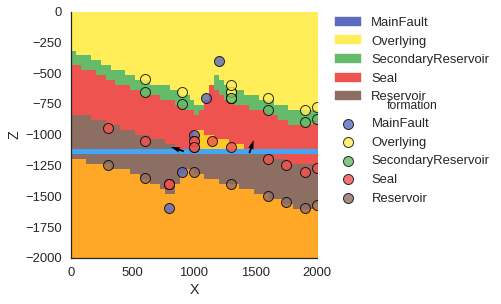

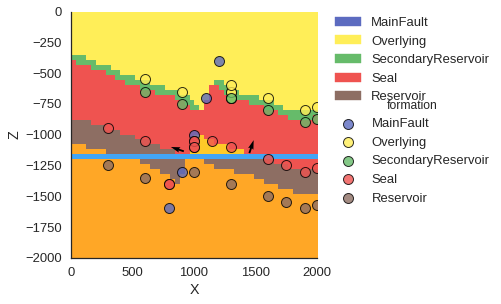

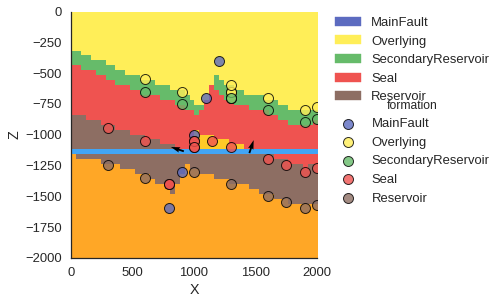

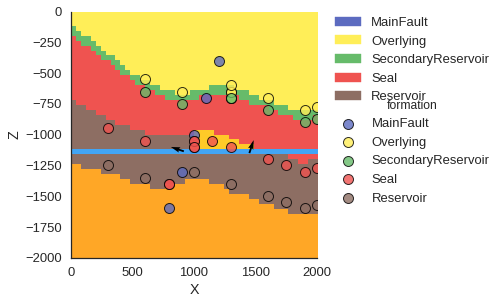

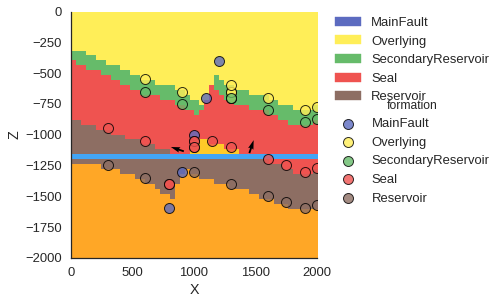

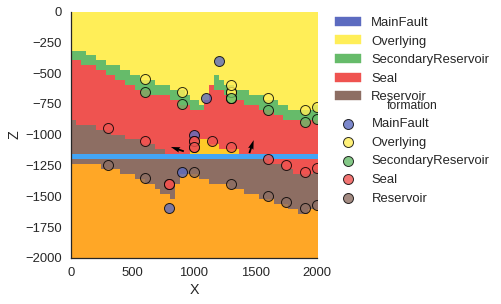

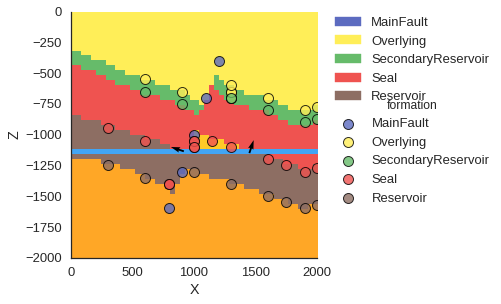

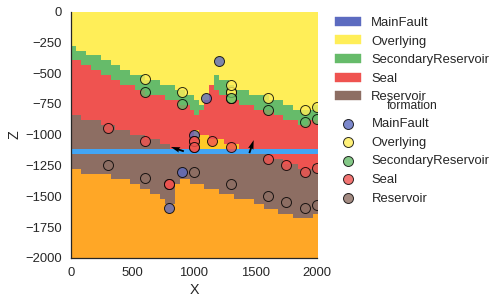

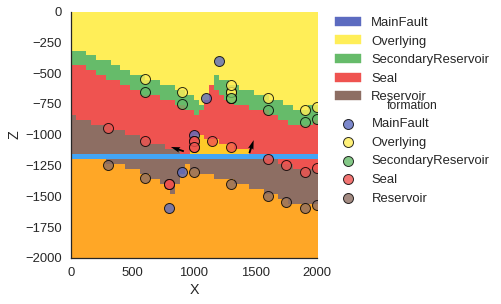

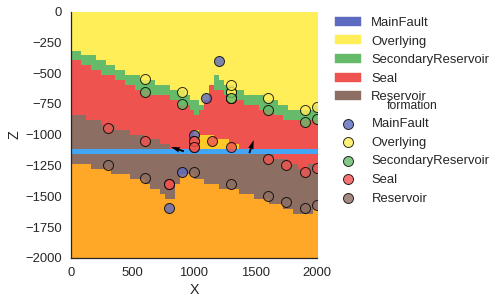

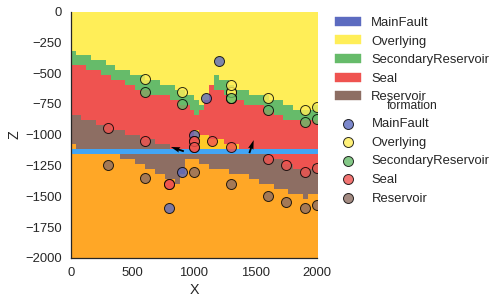

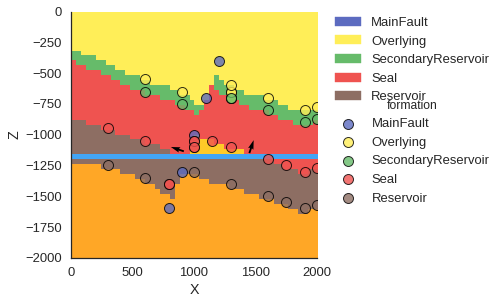

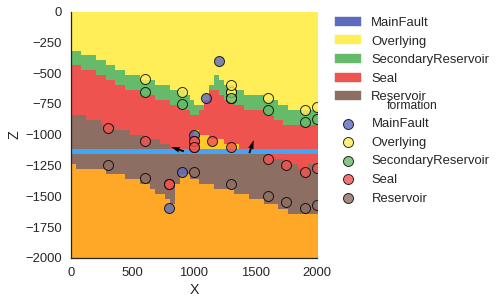

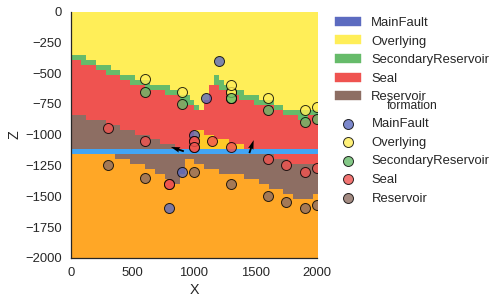

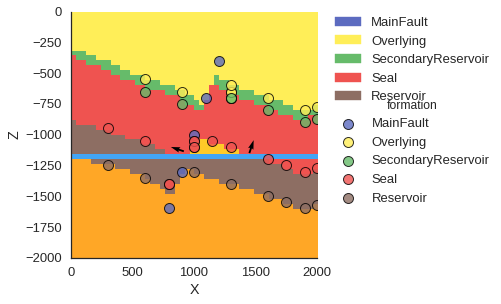

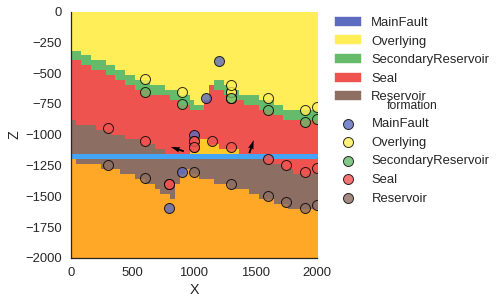

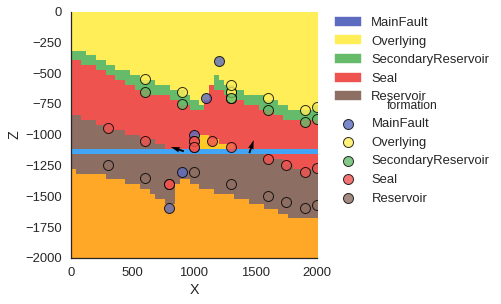

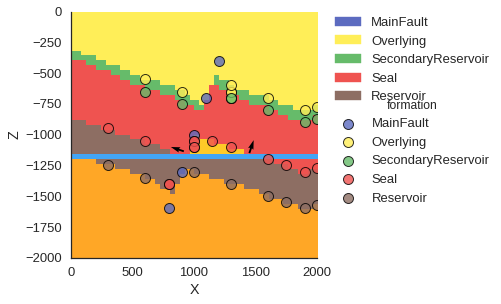

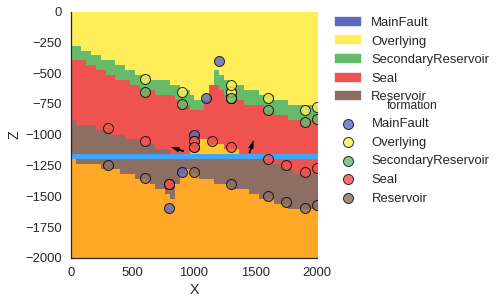

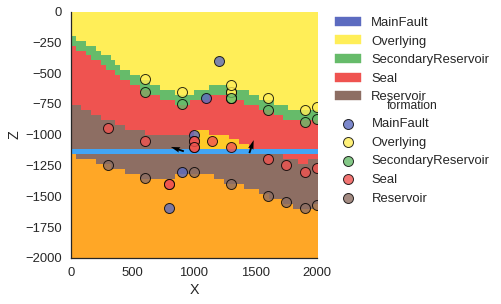

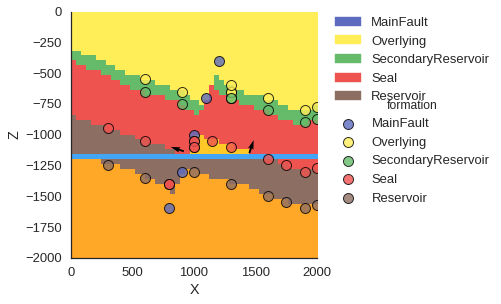

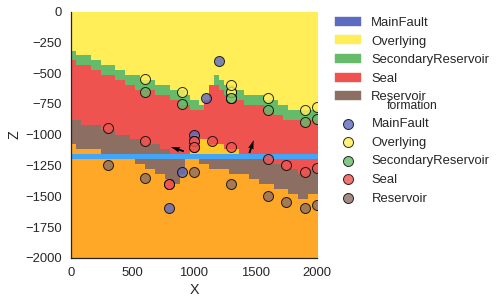

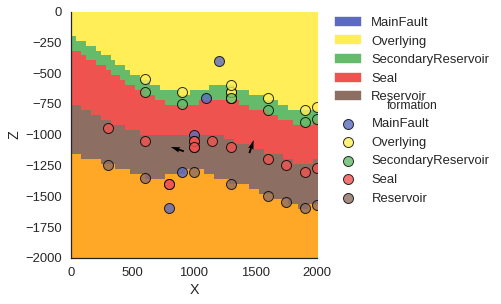

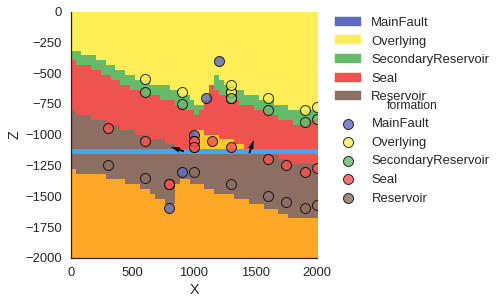

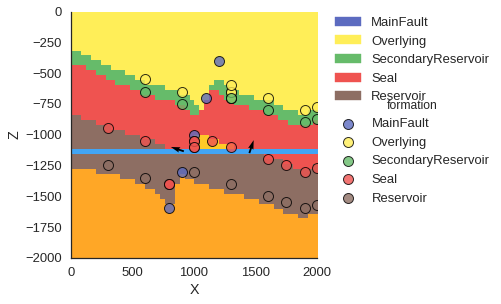

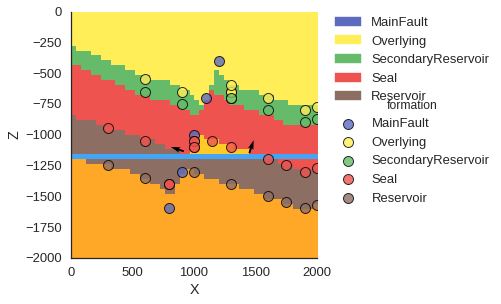

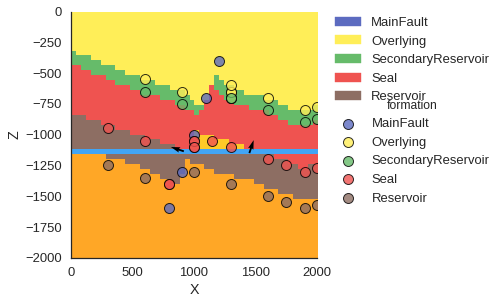

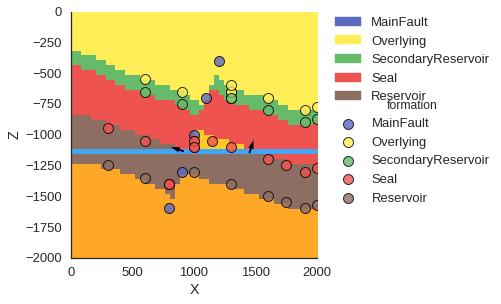

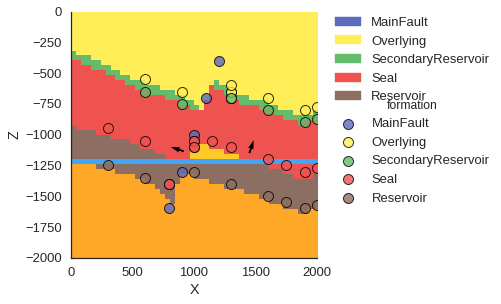

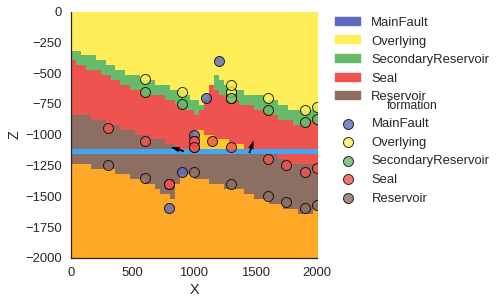

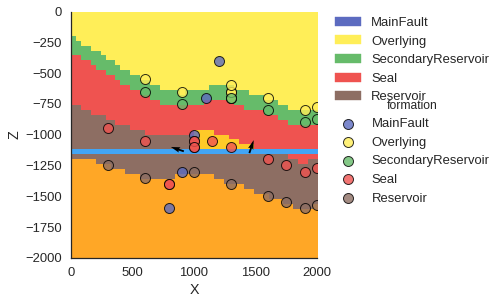

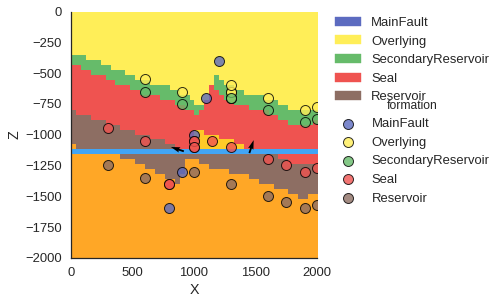

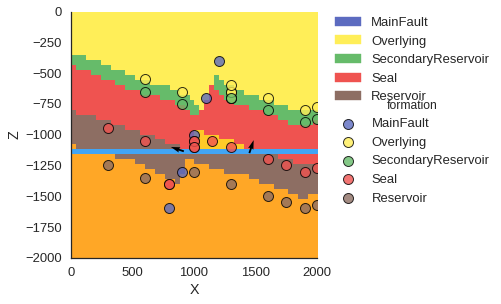

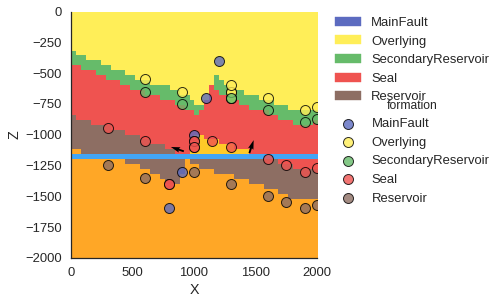

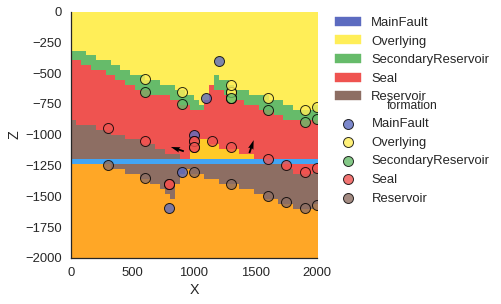

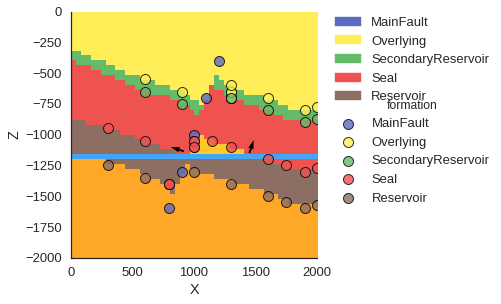

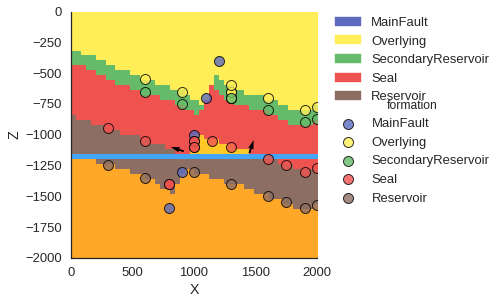

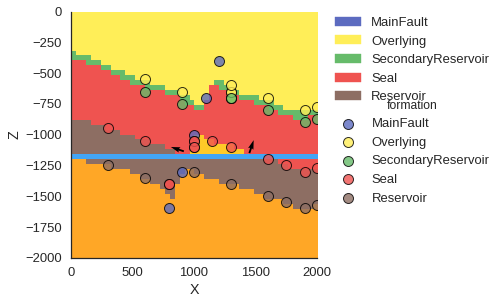

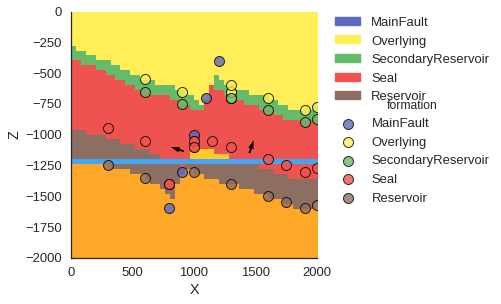

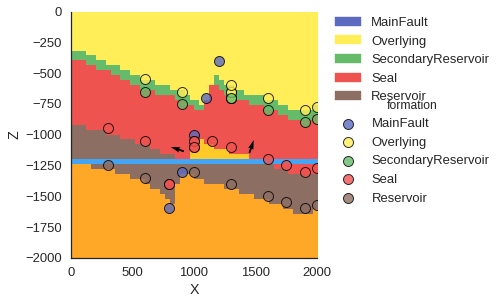

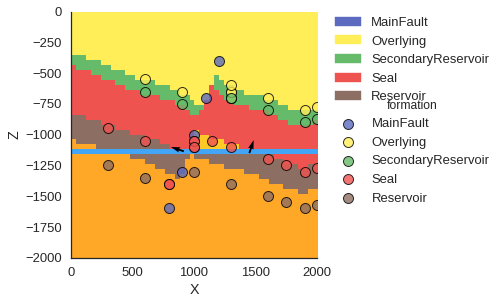

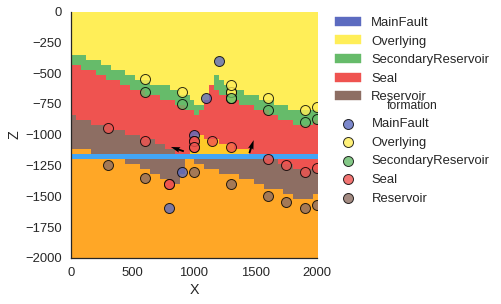

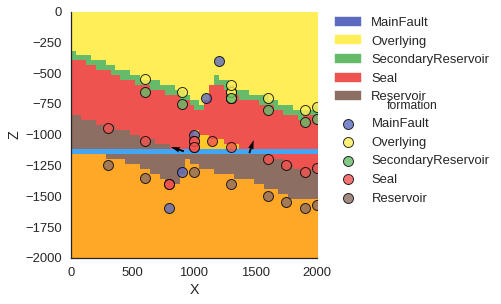

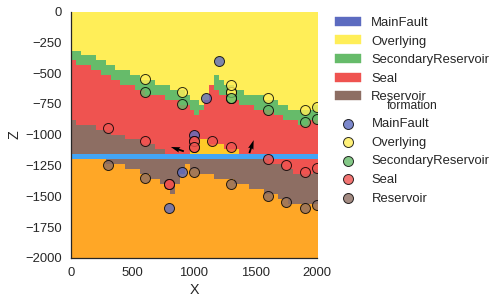

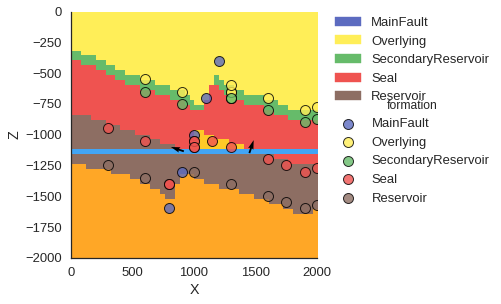

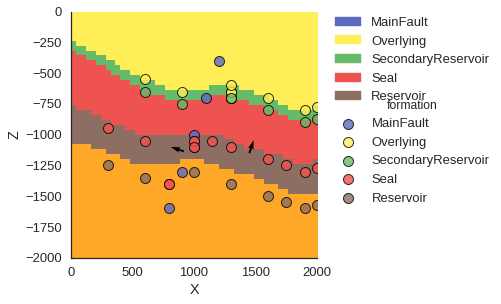

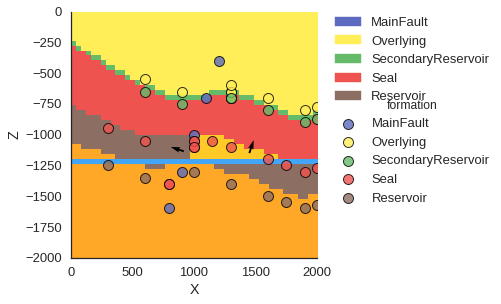

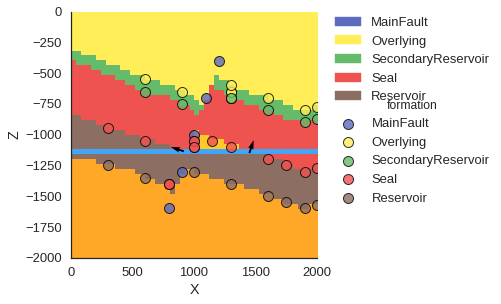

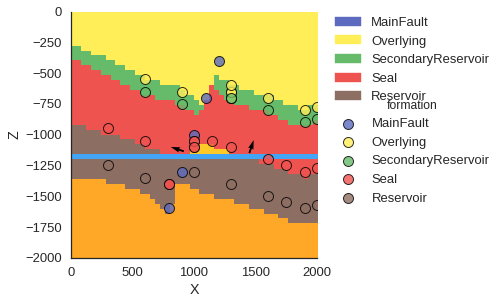

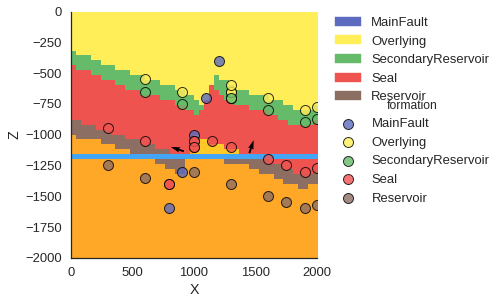

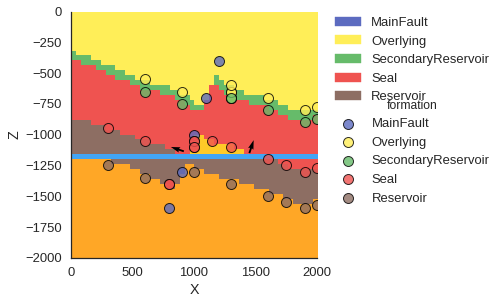

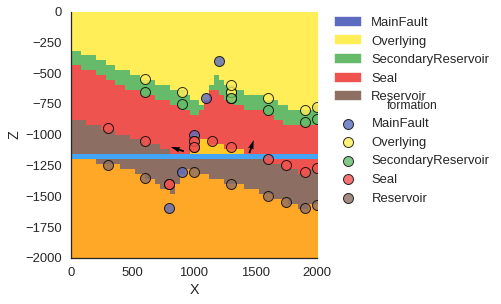

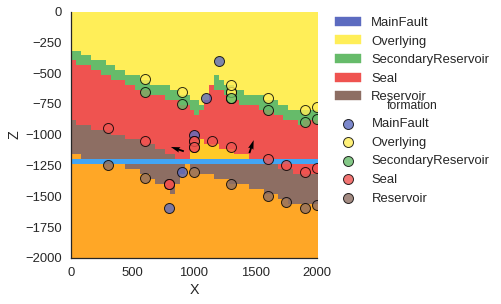

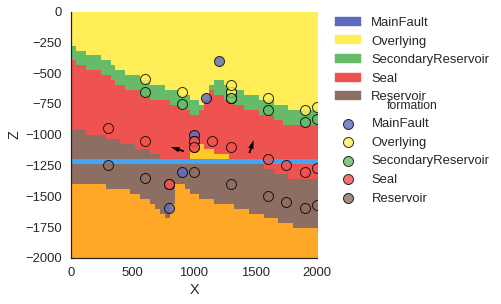

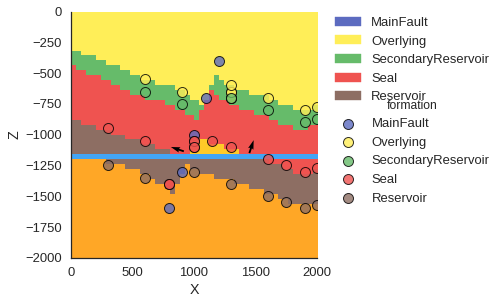

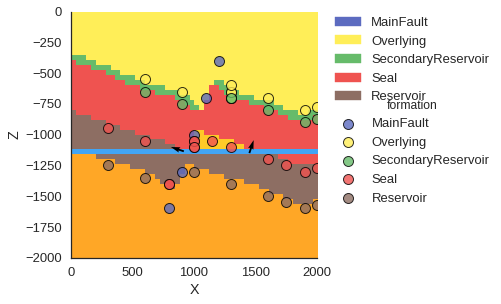

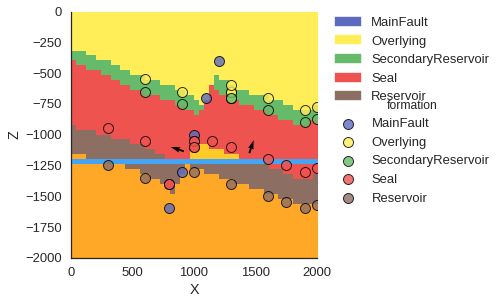

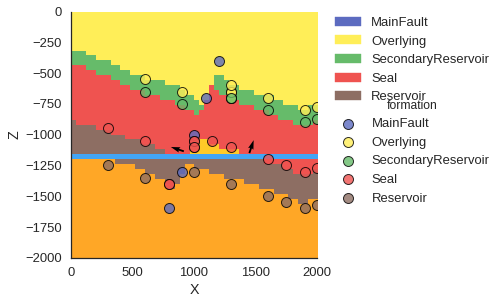

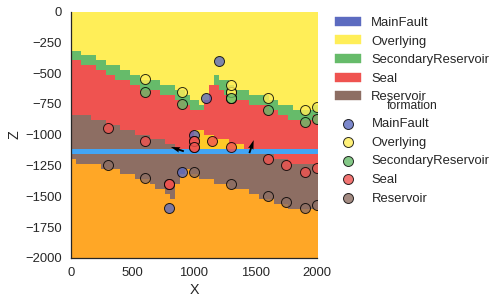

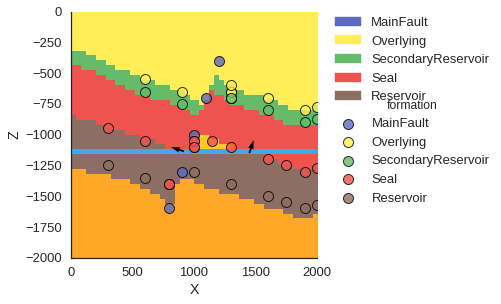

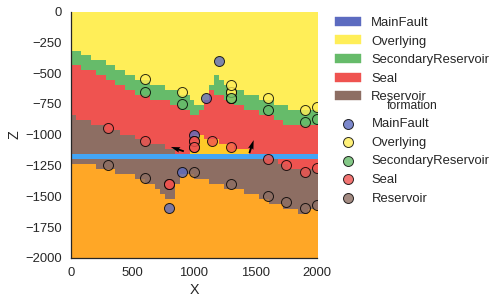

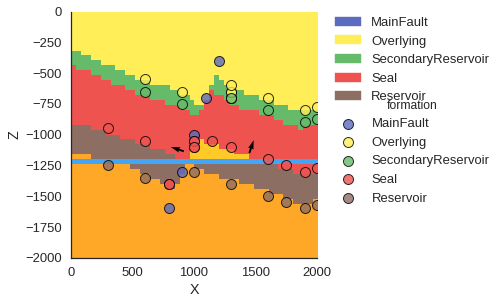

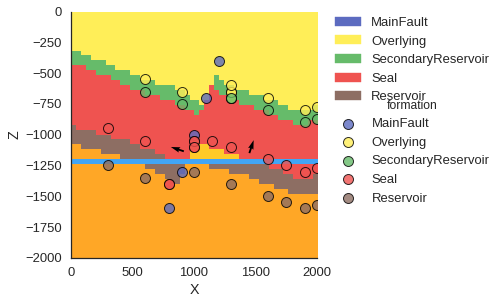

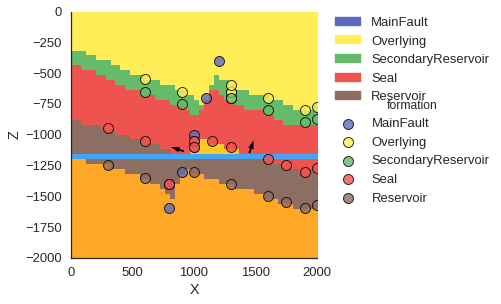

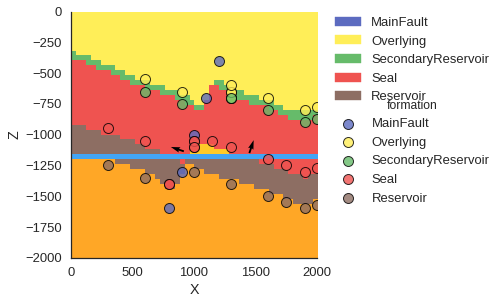

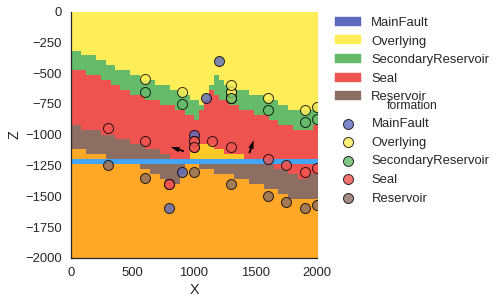

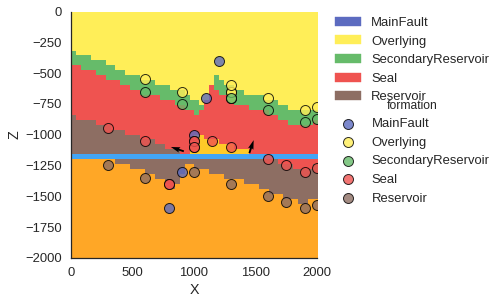

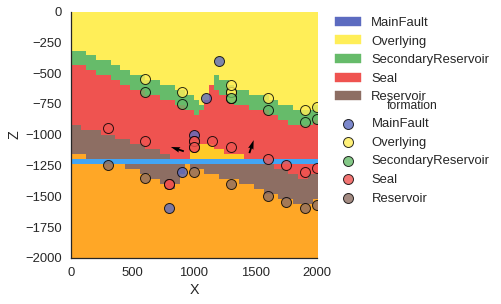

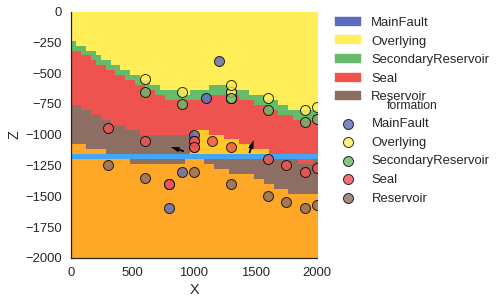

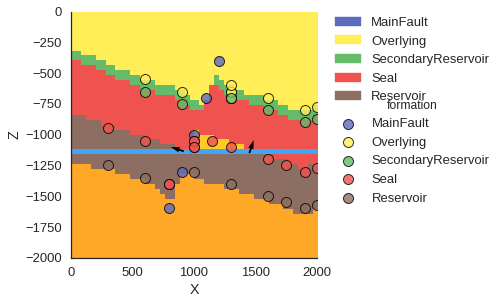

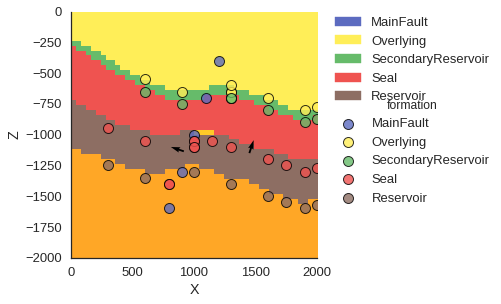

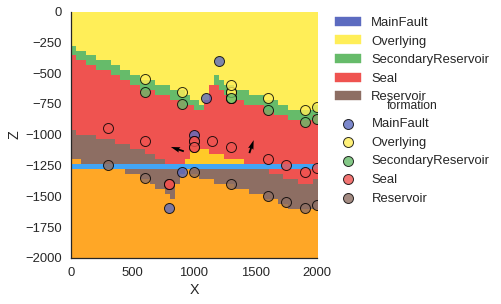

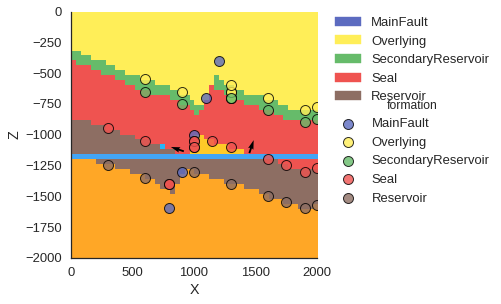

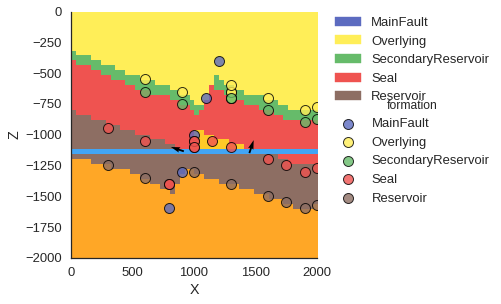

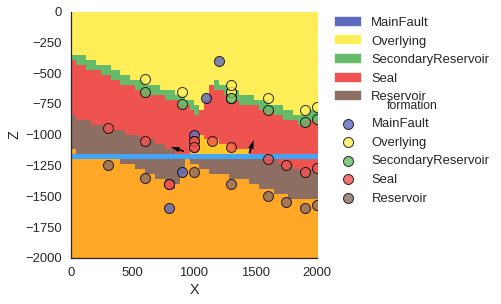

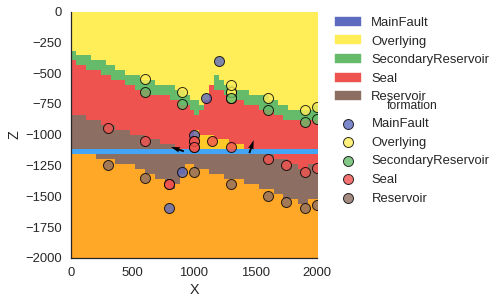

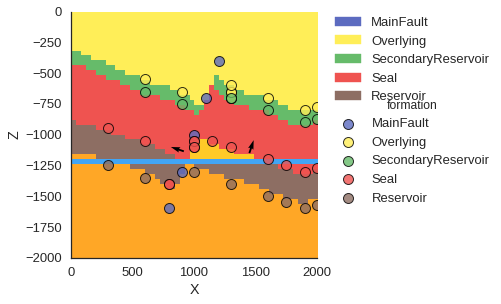

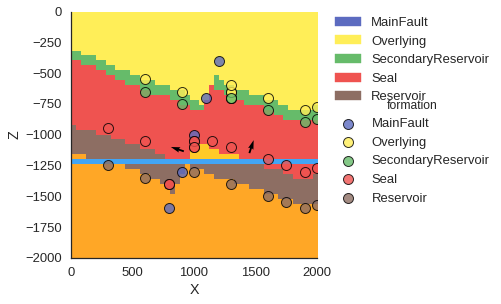

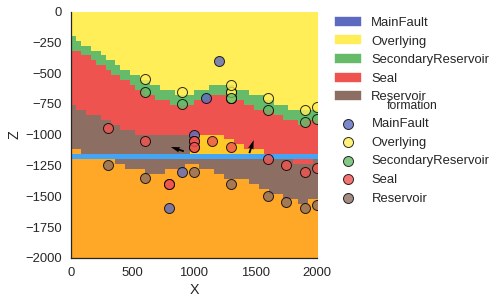

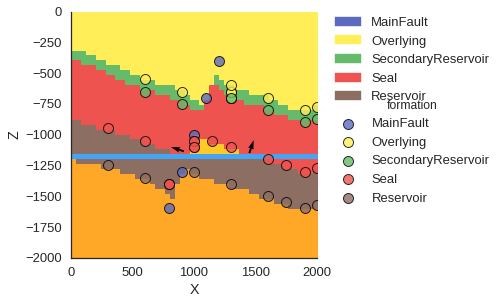

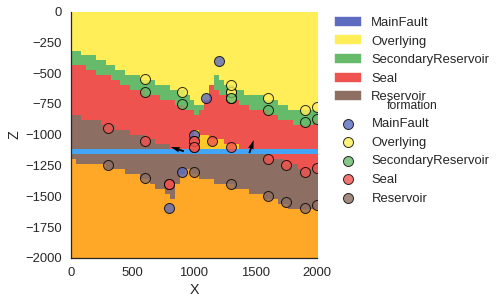

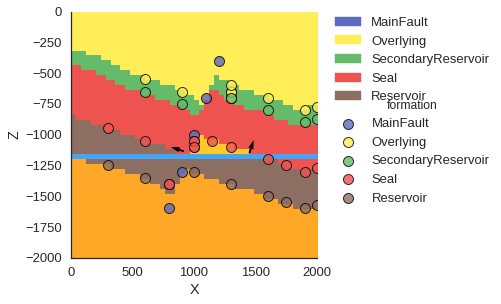

In [30]:
M = pymc.MCMC(model)
M.sample(iter=iterations)

In [31]:
res_top_unc_trace = M.trace('z_unc_res_top')[:]
fault_sealing_trace = M.trace('fault_sealing_unc')[:]
structural_model_trace = M.trace('structural_model')[:] #[0]=lith_sol,[1]=fault:sol,[2]=max_volume

fw_res_th_trace = M.trace('res_th')[:]
fw_seal_th_trace = M.trace('seal_th')[:]
fw_sec_res_th_trace = M.trace('sec_res_th')[:]

#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

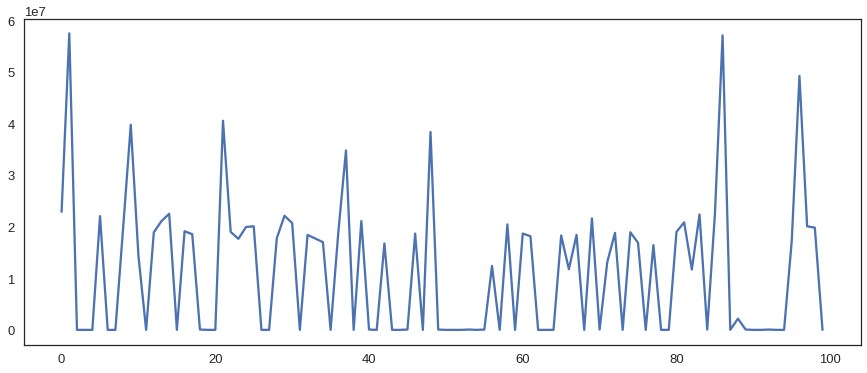

In [32]:
max_volume_trace = structural_model_trace[:,2]
plt.plot(max_volume_trace)

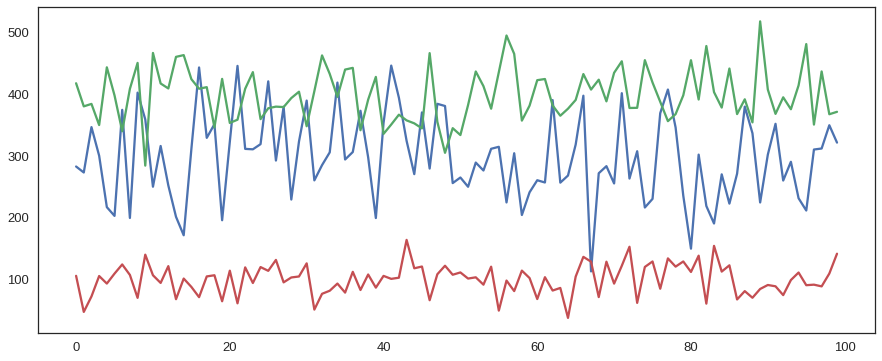

In [33]:
plt.plot(fw_res_th_trace)
plt.plot(fw_seal_th_trace)
plt.plot(fw_sec_res_th_trace)

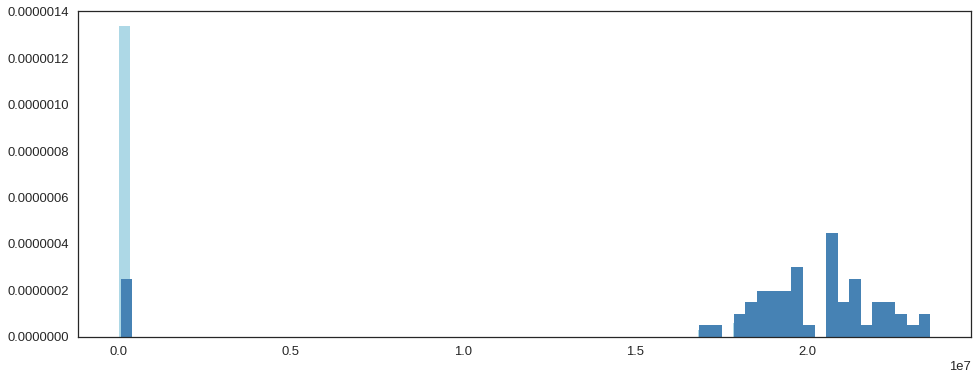

In [48]:
figsize(16, 6)

#_hist1 = plt.hist(max_volume_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")
volumes = max_volume_trace
mask = volumes == 0
masked_trace = volumes[~mask]
_hist1 = plt.hist(max_volume_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "lightblue")
_hist1 = plt.hist(masked_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")

In [35]:
#LOSS FUNCTIONS
estimates_s = np.arange(0,60000000, 10000)

#weight factors
ov = 1.25
ov_b = 2
uv_b = 1.5

#risk parameters
risks_s = np.arange(0.5, 1.6, 0.25)

#risk neutral
def volume_loss4(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*uv_b
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*ov_b
        return loss_s

#including risk
def volume_lossR(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s == 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s == 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
        loss_s[overest_bad] = np.abs((true_s[overest_bad]-estimate_s))*(ov_b*risk_s)
        return loss_s
    
#def volume_lossR(estimate_s, true_s, risk_s):
#        loss_s = np.zeros_like(true_s)
#        underest = (estimate_s < true_s) 
#        underest_bad = (estimate_s <= 0) & (true_s > 0)
#        overest = (estimate_s > true_s) 
#        overest_bad = (estimate_s > 0) & (true_s <= 0)
#        loss_s[underest] = (true_s[underest] - estimate_s)
#        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
#        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
#        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*(ov_b*risk_s)
#        return loss_s

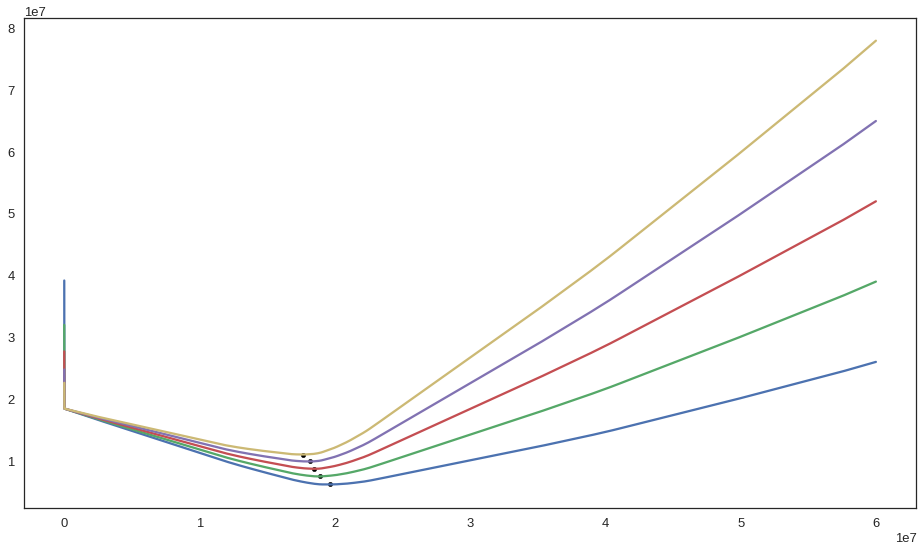

In [36]:
figsize(16, 9)

# No reduced uncertainty, different risks
BA_before = np.zeros_like(risks_s)
EL_before = np.zeros_like(risks_s)
expected_loss = lambda estimate_s, risk_s: volume_lossR(estimate_s, masked_trace, risk_s).mean()

counter = 0
for r in risks_s:
    loss = [expected_loss(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss, -40, args=(r,),disp = False)
    #print(_min_score)
    if _min_score < 0:
        _min_score = 0
    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
    plt.scatter(_min_score, expected_loss(_min_score,r), s = 20, color = 'black')
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_before[counter] = _min_score
    EL_before[counter] = expected_loss(_min_score,r)
    counter += 1


In [37]:
# ADDING THICKNESS LIKELIHOOD FUNCTIONS
#Additional information, updating with likelihoods

#return fw_res_th, fw_seal_th, fw_sec_res_th, fw_rb_z, fw_sb_z, fw_r2b_z, fw_ob_z

std1 = 10
std2 = 20
std3 = 50

@pymc.stochastic
def res_th_likelihood(value = 0, res_th=res_th):
    return pymc.normal_like(res_th, 250., 1./np.square(std3))

@pymc.stochastic
def seal_th_likelihood(value = 0, seal_th=seal_th):
    return pymc.normal_like(seal_th, 400., 1./np.square(std2))

@pymc.stochastic
def sec_res_th_likelihood(value = 0, sec_res_th=sec_res_th):
    return pymc.normal_like(sec_res_th, 120., 1./np.square(std1))

Z-Variations top to bottom: 0.003904605160802519 -0.006596704965318629 0.0025350609494927978 -0.004292403387974666
Z-Variations top to bottom: 0.003904605160802519 -0.006596704965318629 0.0025350609494927978 -0.001855955830874157
Z-Variations top to bottom: 0.003904605160802519 -0.02002662195029751 0.0025350609494927978 -0.001855955830874157
Z-Variations top to bottom: 0.0032800017934278567 -0.006596704965318629 0.0025350609494927978 -0.001855955830874157


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:57: UserWarning: Boolean Serie

Spill point defines trap.
Fault is sealing. Down to spill.


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [                  2%                  ] 2 of 100 complete in 9.0 secZ-Variations top to bottom: 0.0032800017934278567 -0.006596704965318629 0.0020093583509893376 -0.001855955830874157
Z-Variations top to bottom: 0.0032800017934278567 -0.006596704965318629 0.0020093583509893376 0.0007920112637114368
Z-Variations top to bottom: 0.0032800017934278567 -0.006680382952861396 0.0020093583509893376 0.0007920112637114368
Z-Variations top to bottom: 0.004379351679712267 -0.006680382952861396 0.0020093583509893376 0.0007920112637114368
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
Checking Section: 19
TRAP FOUND, section: 19
Maximum reservoir volume: 64000.0 m³
 [-                 3%                  ] 3 of 100 complete in 16.8 secZ-Variations top to bottom: 0.0032800017934278567 -0.006680382952861396 0.0014728302802727937 0.0007920112637114368
Z-Variations top to bottom: 0.0032800017934278

/home/bl9/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [----             12%                  ] 12 of 100 complete in 88.7 secZ-Variations top to bottom: -0.002095559509160771 -0.004609330599989929 -0.0016159193181057578 -0.01016804170834332
Z-Variations top to bottom: -0.002095559509160771 -0.004609330599989929 -0.0016159193181057578 -0.0050950221777660175
Z-Variations top to bottom: -0.002095559509160771 -0.006599211616262047 -0.0016159193181057578 -0.0050950221777660175
Z-Variations top to bottom: -0.005804918581781833 -0.006599211616262047 -0.0016159193181057578 -0.0050950221777660175
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 15
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [----             13%                  ] 13 of 100 complete in 97.0 secZ-Variations top to bottom: -0.002095559509160771 -0.006599211616262047 -8.405042011641519e-05 -0.0050950221777660175
Z-Variations top to bottom: -0.002095559509160771 -0.006599211616

Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 17
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Maximum reservoir volume: 21248000.0 m³
 [---------        24%                  ] 24 of 100 complete in 186.2 secZ-Variations top to bottom: 0.002219087527179115 -0.0016129471559865357 -0.0037594713618257646 0.003769985558616097
Z-Variations top to bottom: 0.002219087527179115 -0.0016129471559865357 -0.0037594713618257646 0.009678080433111677
Z-Variations top to bottom: 0.002219087527179115 0.0017030245186172499 -0.0037594713618257646 0.009678080433111677
Z-Variations top to bottom: 0.009260937307439836 -0.0016129471559865357 -0.0037594713618257646 0.009678080433111677
Z-Variations top to bottom: 0.002219087527179115 -0.0016129471559865357 -0.0037594713618257646 0.009678080433111677
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 17
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Maximum reservoi

Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-------------    35%                  ] 35 of 100 complete in 274.8 secZ-Variations top to bottom: 0.005025048603548653 0.00350484443920082 -0.0019050227454218247 0.003830113930228518
Z-Variations top to bottom: 0.005025048603548653 0.00350484443920082 -0.0019050227454218247 0.004679309618305025
Z-Variations top to bottom: 0.005025048603548653 0.006018713283305439 -0.0019050227454218247 0.004679309618305025
Z-Variations top to bottom: 0.005564315046364232 0.00350484443920082 -0.0019050227454218247 0.004679309618305025
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-------------    36%                  ] 36 of 100 complete in 282.9 secZ-Variations top to bottom: 0.005564315046364232 0.00350484443920082 -0.00021598508244980103 0.004679309618305025
Z-Variations top to botto

Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 17
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Maximum reservoir volume: 22528000.0 m³
 [-----------------47%                  ] 47 of 100 complete in 370.7 secZ-Variations top to bottom: 0.00914999654264952 -0.0007294743553654605 -0.0033835537916874357 0.00443547512649095
Z-Variations top to bottom: 0.00914999654264952 -0.0007294743553654605 -0.0033835537916874357 0.010032565178804666
Z-Variations top to bottom: 0.00914999654264952 0.0008830590676487252 -0.0033835537916874357 0.010032565178804666
Z-Variations top to bottom: 0.012352798991910713 0.0008830590676487252 -0.0033835537916874357 0.010032565178804666
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 9
TRAP FOUND, section: 9
Checking Section: 18
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 15
Maximum reservoir volume: 22208000.0 m³
 [-----------------48%                  ] 48 of 100 co

Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 17
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Maximum reservoir volume: 21120000.0 m³
 [-----------------58%--                ] 58 of 100 complete in 459.2 secZ-Variations top to bottom: 0.0005618244740592908 -0.0040502860348158205 -0.0036770663808687147 0.008091496737569365
Z-Variations top to bottom: 0.0005618244740592908 -0.0040502860348158205 -0.0036770663808687147 0.005784606266933185
Z-Variations top to bottom: 0.0005618244740592908 -0.013775916449308716 -0.0036770663808687147 0.005784606266933185
Z-Variations top to bottom: 0.00020623779027715097 -0.0040502860348158205 -0.0036770663808687147 0.005784606266933185
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 17
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Maximum reservoir volume: 21504000.0 m³
 [-----------------59%--                ] 59 of 100 complete in 467.1 secZ-Variations t

Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 18
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 15
Maximum reservoir volume: 18048000.0 m³
 [-----------------69%------            ] 69 of 100 complete in 548.3 secZ-Variations top to bottom: 0.001860959556506194 -0.002715149492259484 -0.006087793770451978 0.025728693817813685
Z-Variations top to bottom: 0.001860959556506194 -0.002715149492259484 -0.006087793770451978 0.019279548481831756
Z-Variations top to bottom: 0.001860959556506194 -0.0038085699407825043 -0.006087793770451978 0.019279548481831756
Z-Variations top to bottom: 0.0022099698154769976 -0.0038085699407825043 -0.006087793770451978 0.019279548481831756
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 18
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 15
Maximum reservoir volume: 18624000.0 m³
 [-----------------70%------            ] 70 of 100 complete in 556.2 secZ-Variations top to bot

Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 18
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 15
Maximum reservoir volume: 19328000.0 m³
 [-----------------80%----------        ] 80 of 100 complete in 637.0 secZ-Variations top to bottom: -0.0006314920871921853 -0.0032003899098811336 -0.004926620194809943 0.017953351429887764
Z-Variations top to bottom: -0.0006314920871921853 -0.0032003899098811336 -0.004926620194809943 0.01934074464661326
Z-Variations top to bottom: -0.0006314920871921853 -0.005966585059286531 -0.004926620194809943 0.017953351429887764
Z-Variations top to bottom: -0.004157862081783762 -0.005966585059286531 -0.004926620194809943 0.017953351429887764
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 18
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 15
Maximum reservoir volume: 19712000.0 m³
 [-----------------81%----------        ] 81 of 100 complete in 644.9 secZ-Variations top t

 [-----------------91%--------------    ] 91 of 100 complete in 725.4 secZ-Variations top to bottom: -0.0005506430392249916 -0.006651262248896856 -0.00963813687889776 0.009432372368878858
Z-Variations top to bottom: -0.0005506430392249916 -0.006651262248896856 -0.00963813687889776 0.01943581562110854
Z-Variations top to bottom: -0.0005506430392249916 -0.0018000988771462384 -0.00963813687889776 0.01943581562110854
Z-Variations top to bottom: 0.004589251909644355 -0.006651262248896856 -0.00963813687889776 0.01943581562110854
Z-Variations top to bottom: -0.0005506430392249916 -0.006651262248896856 -0.00963813687889776 0.01943581562110854
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 20
TRAP FOUND, section: 20
Checking Section: 15
Maximum reservoir volume: 64000.0 m³
 [-----------------92%--------------    ] 92 of 100 complete in 733.6 secZ-Variations top to bottom: -0.0005506430392249916 -0.006651262248896856 -0.009803597356918698 0.01943581562110854
Z-Varia

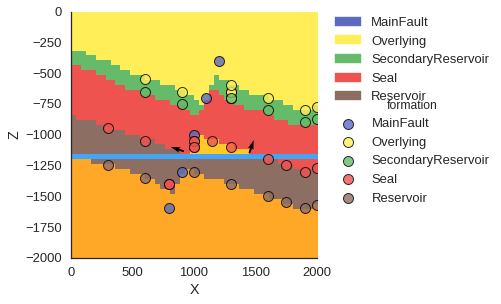

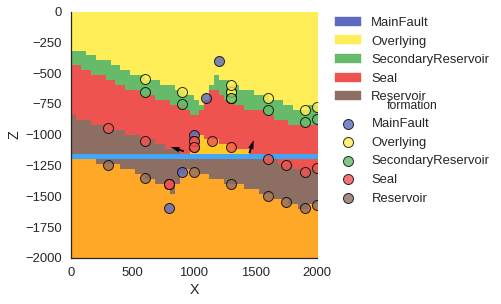

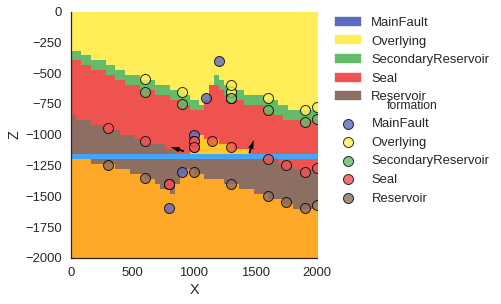

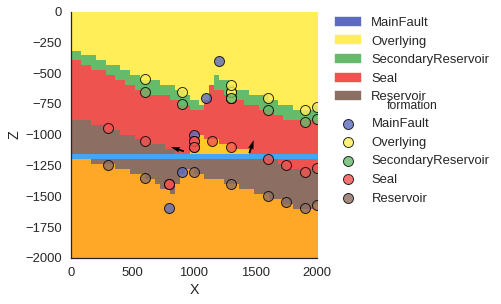

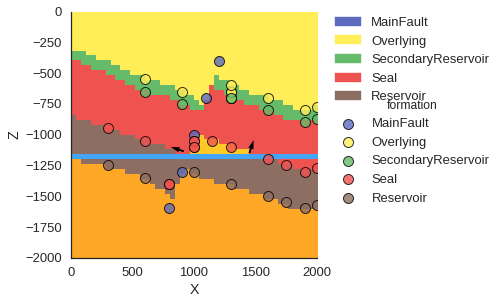

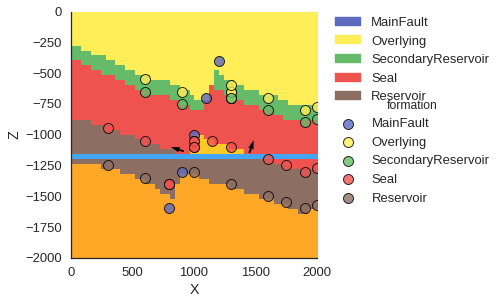

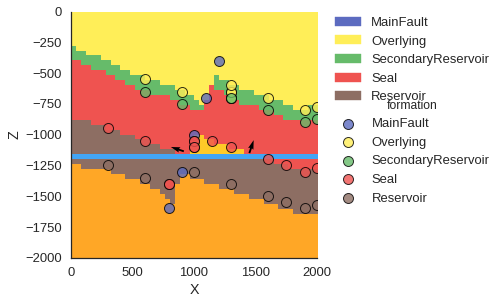

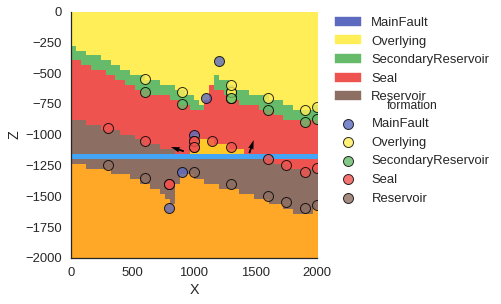

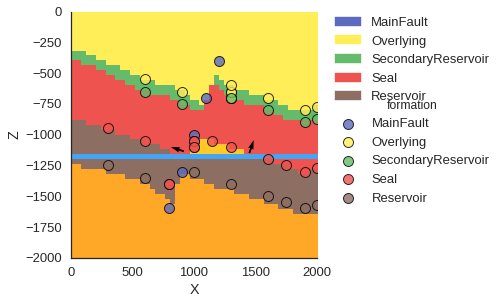

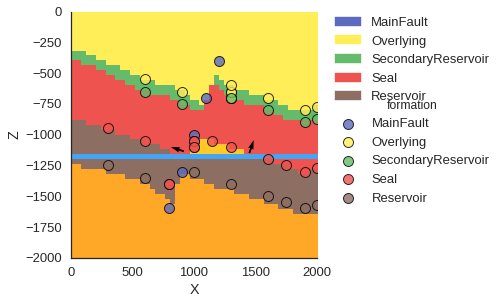

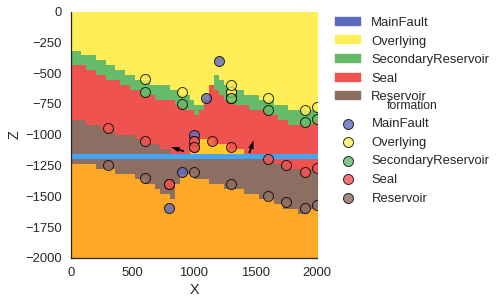

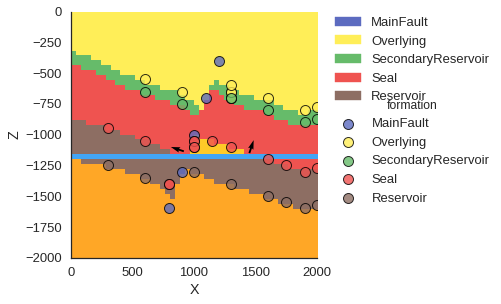

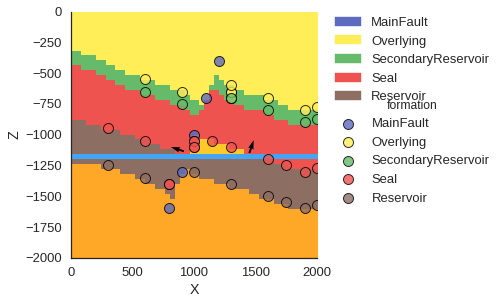

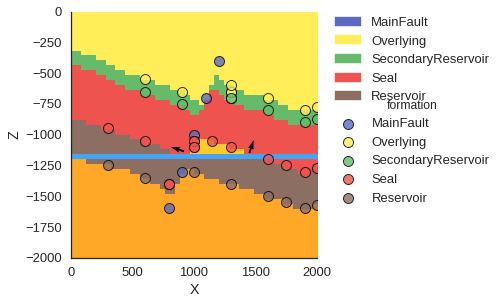

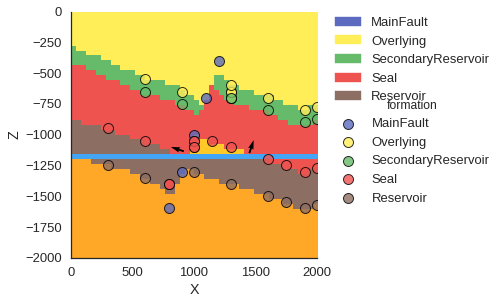

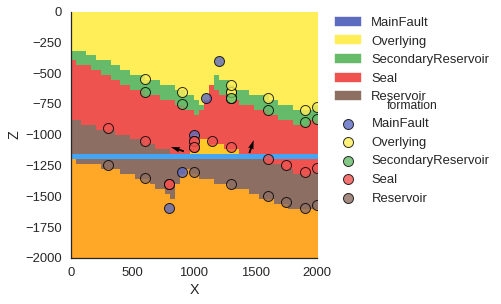

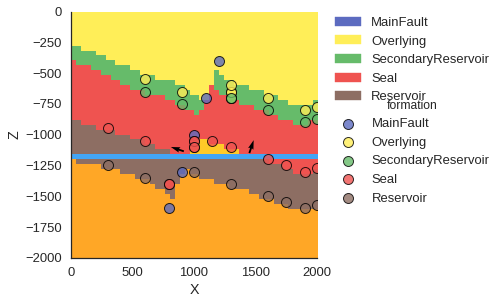

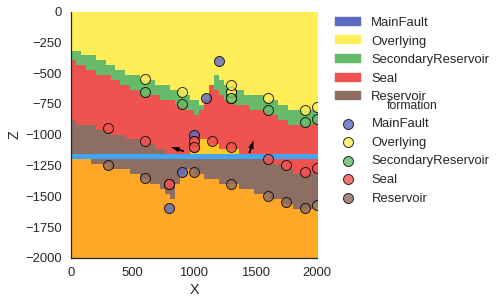

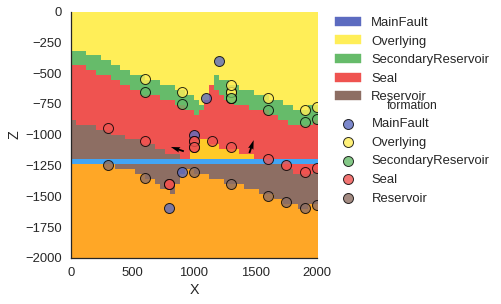

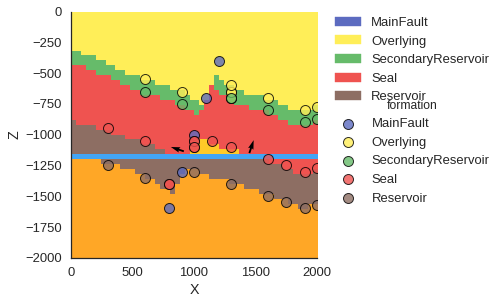

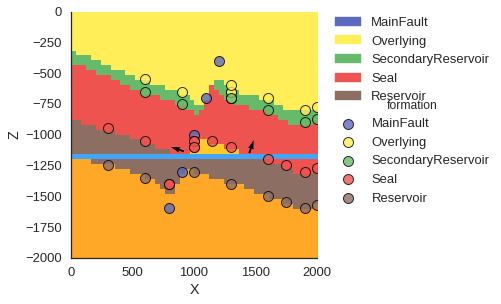

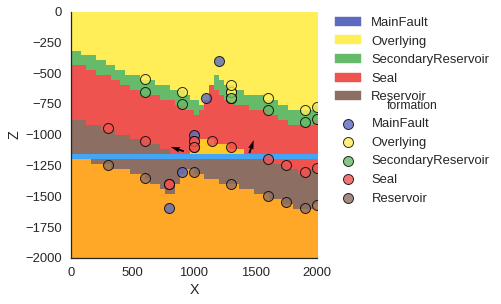

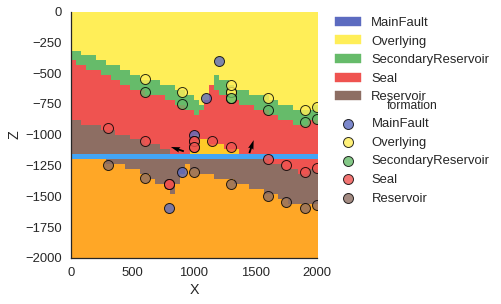

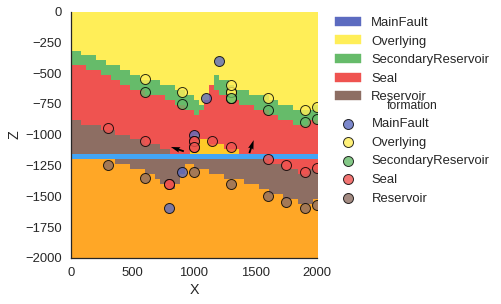

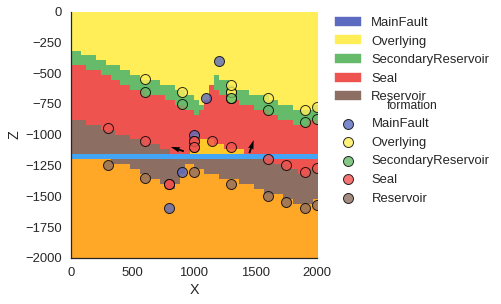

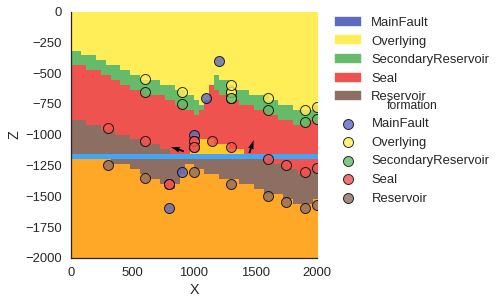

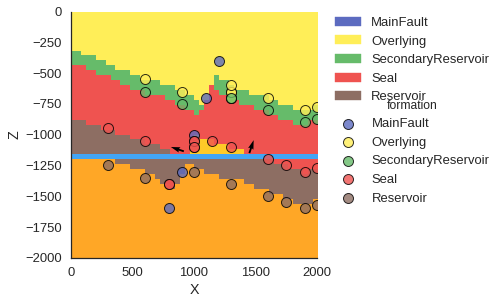

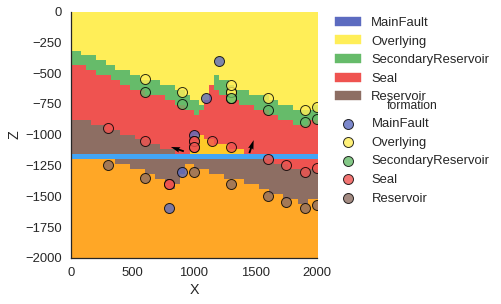

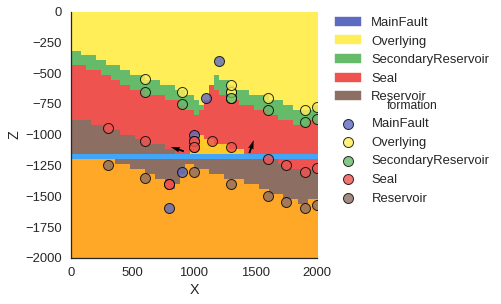

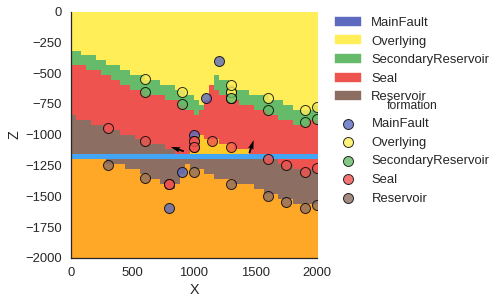

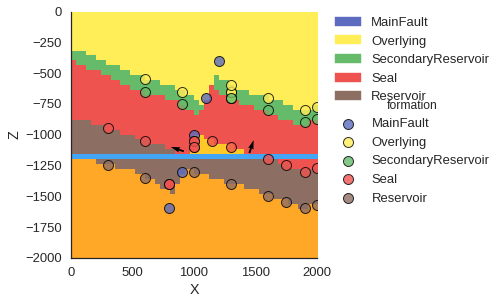

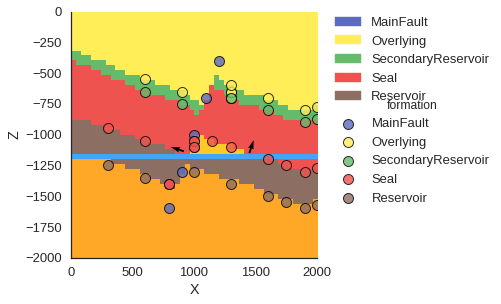

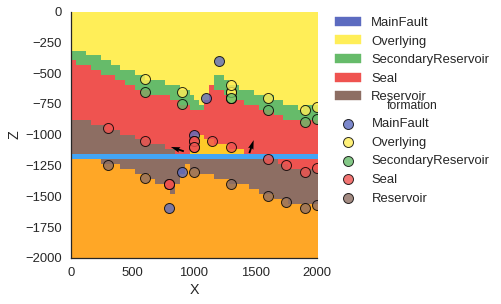

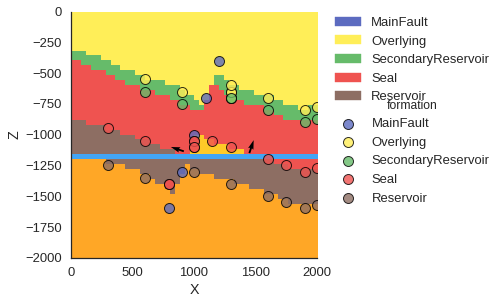

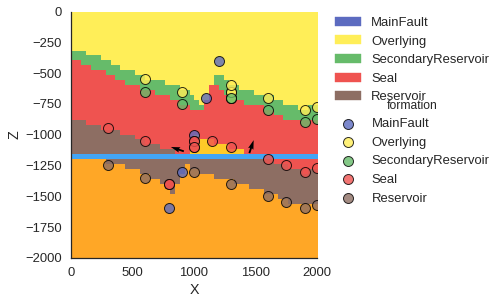

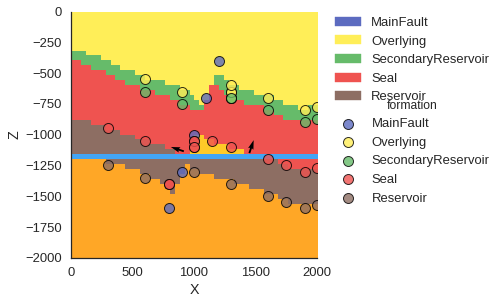

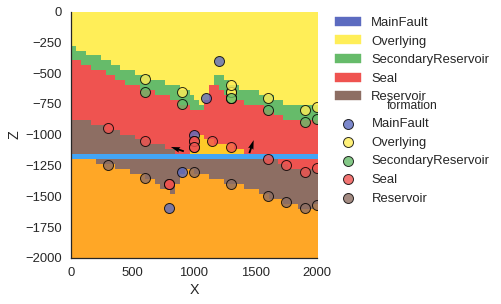

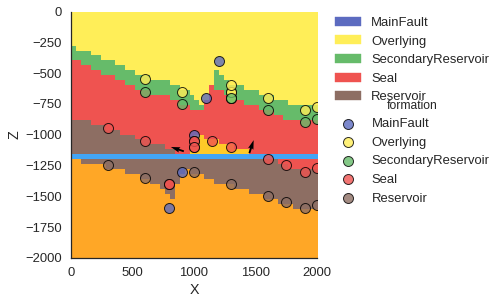

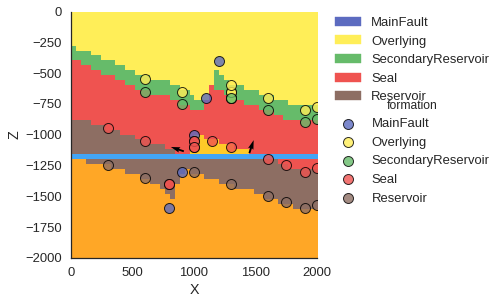

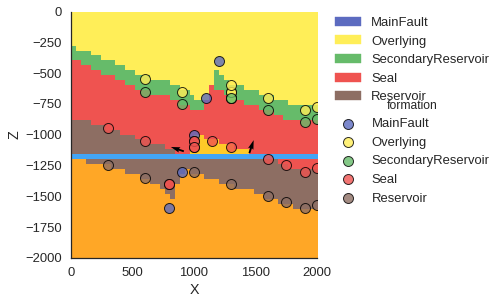

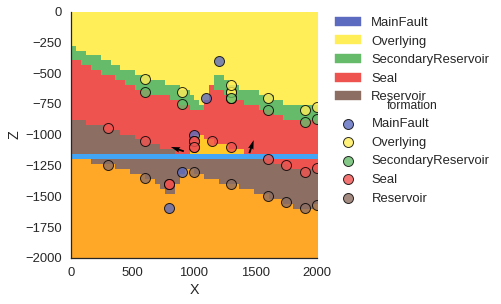

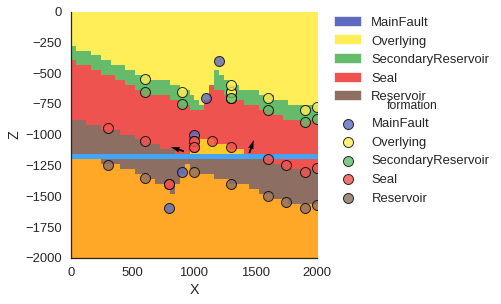

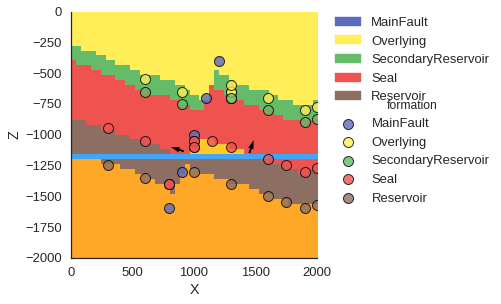

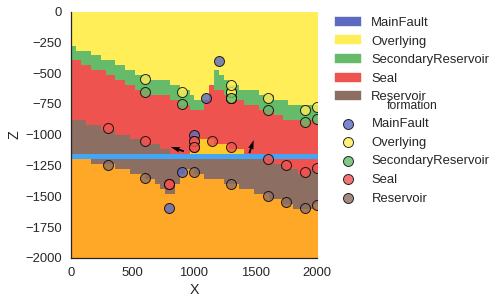

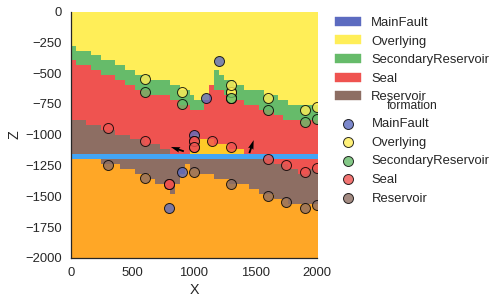

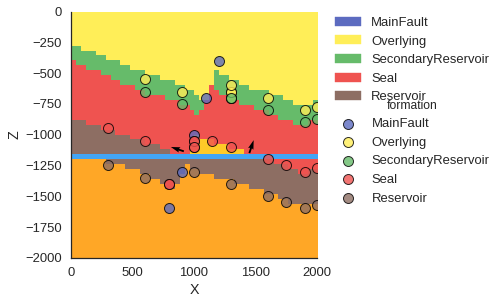

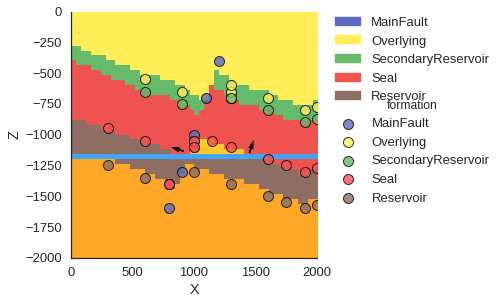

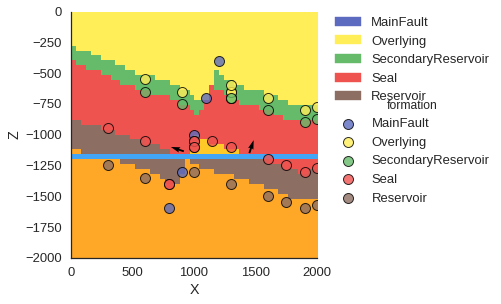

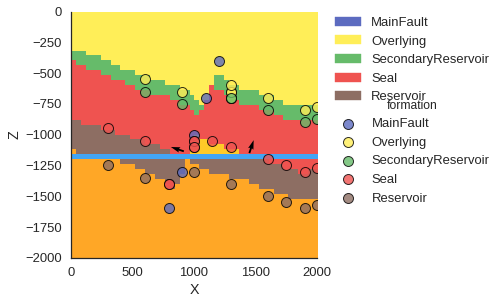

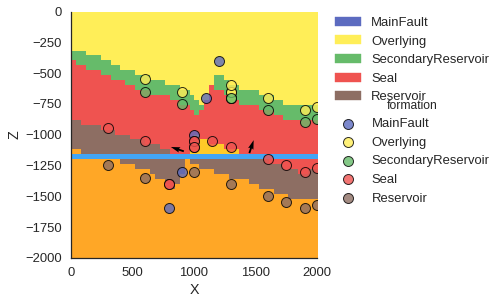

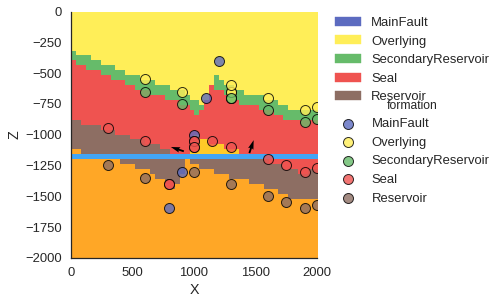

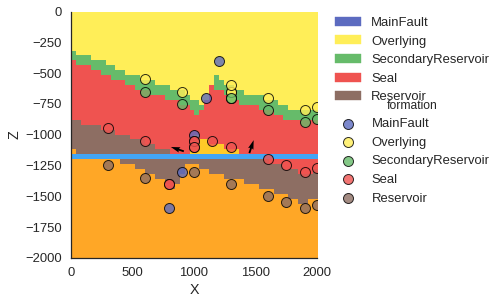

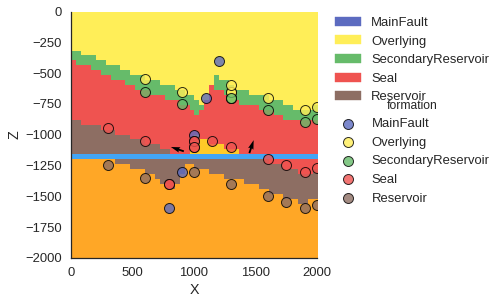

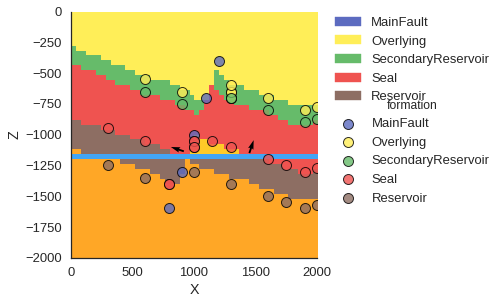

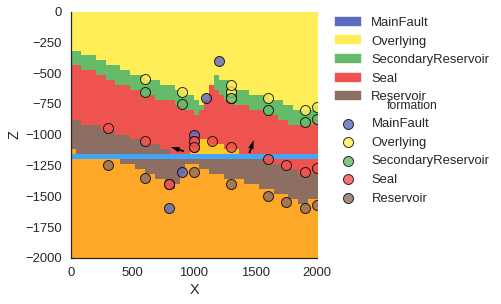

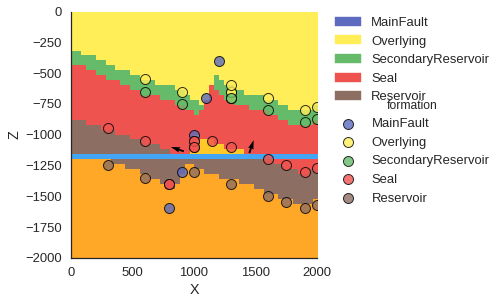

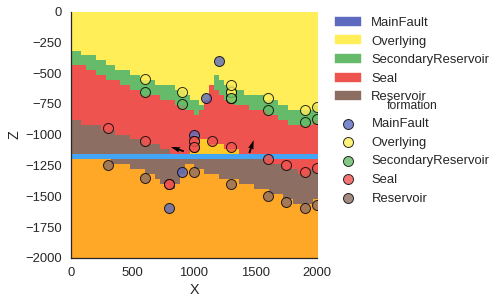

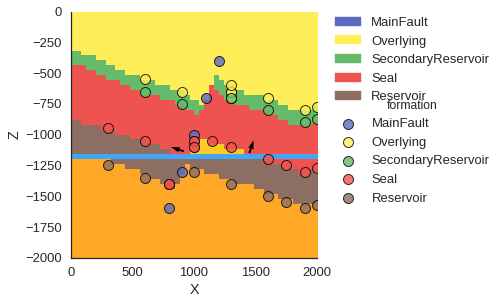

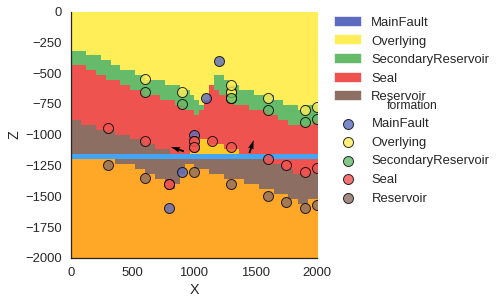

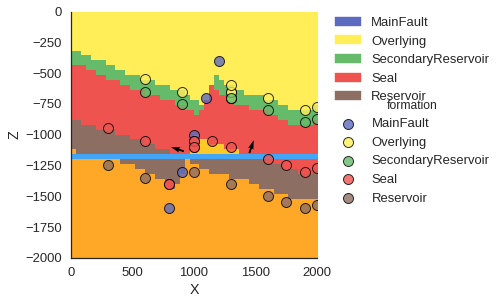

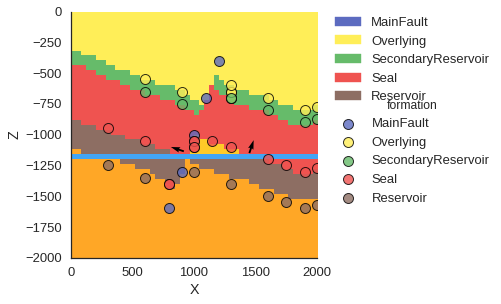

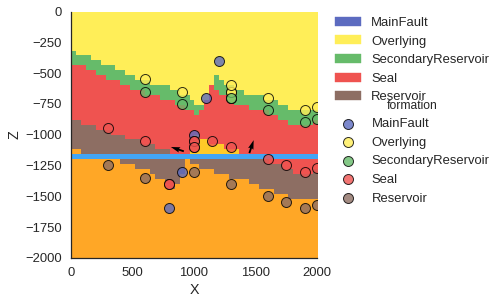

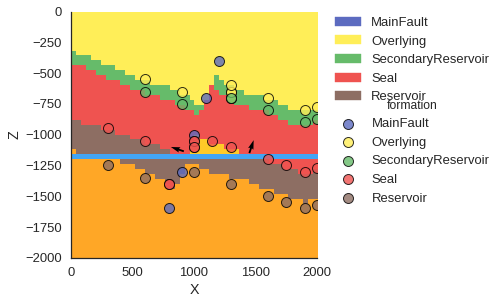

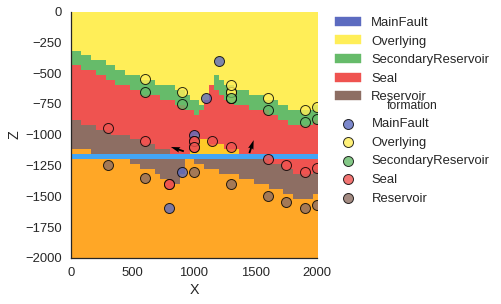

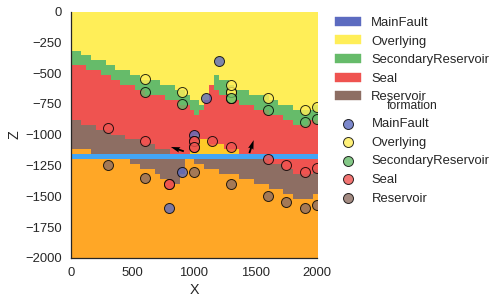

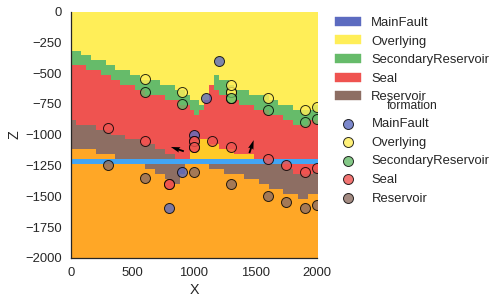

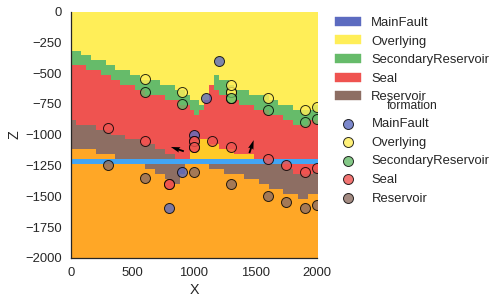

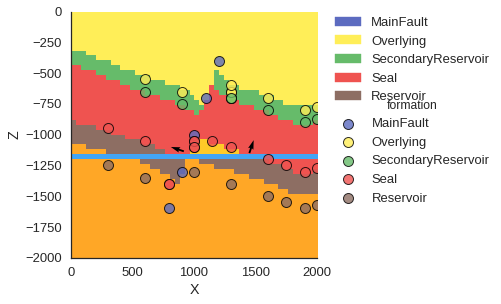

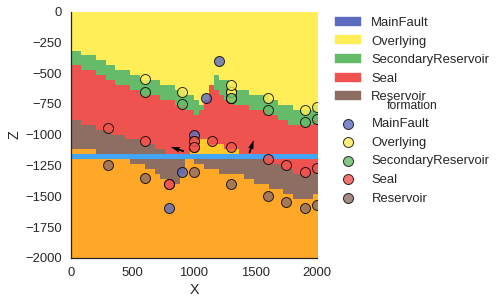

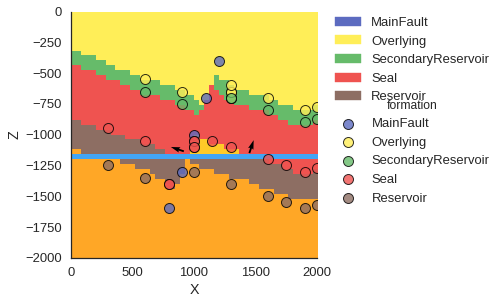

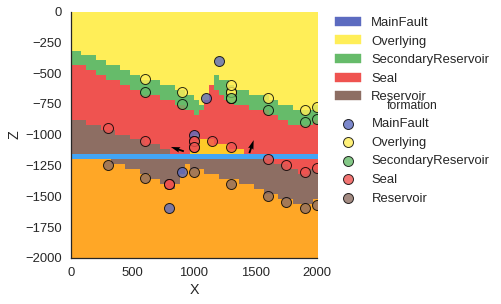

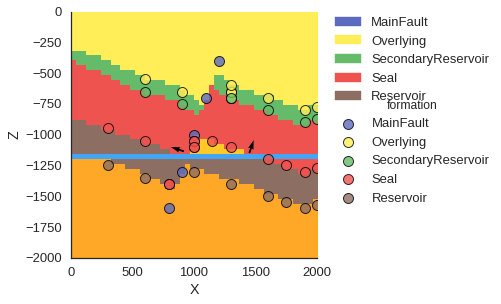

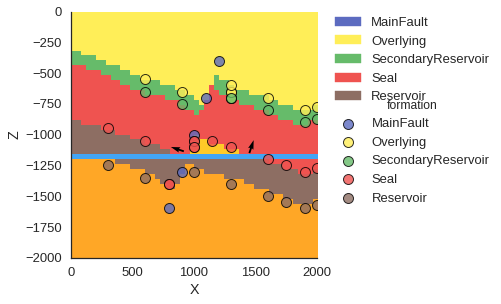

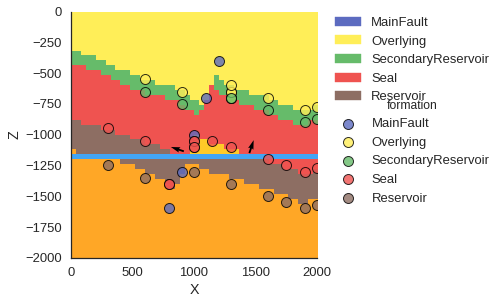

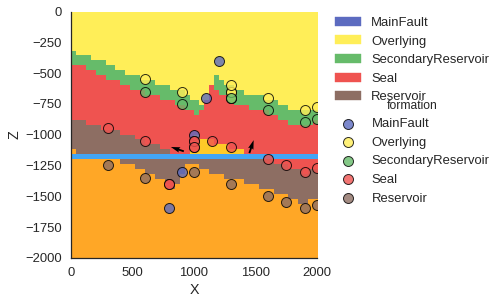

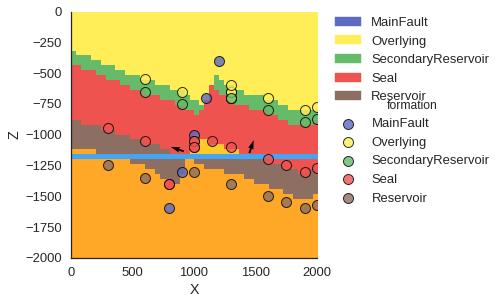

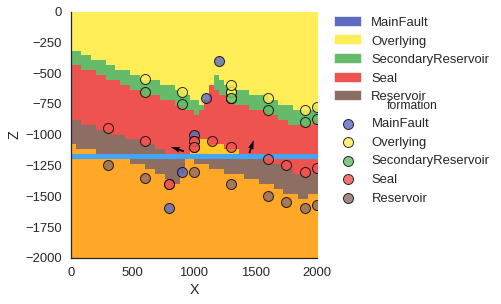

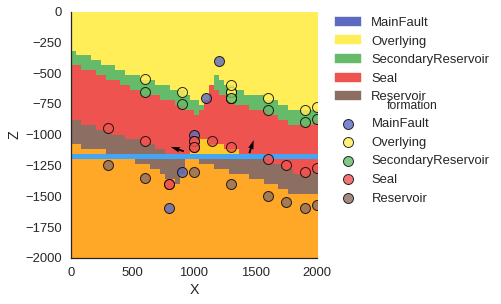

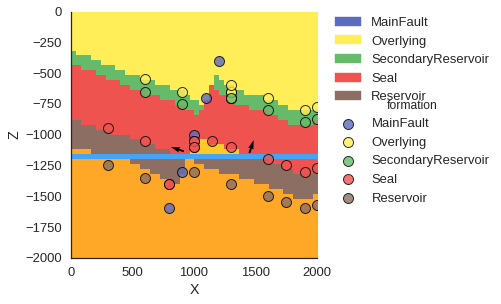

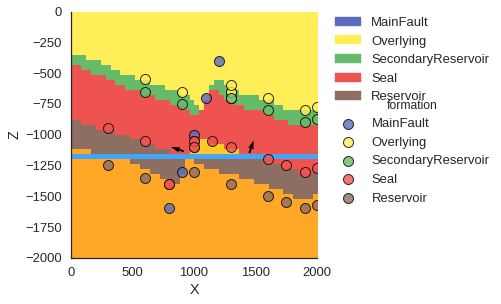

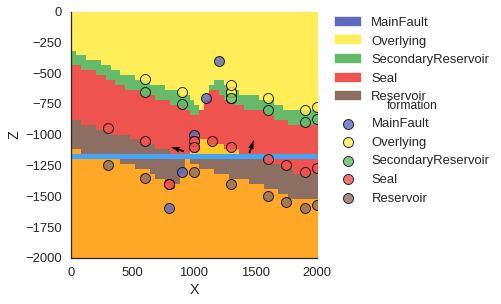

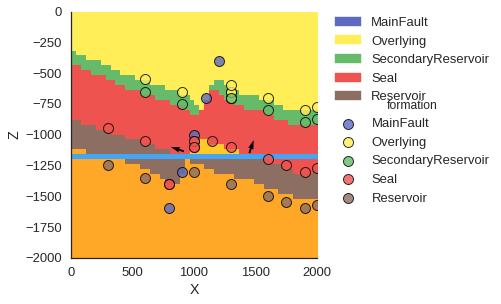

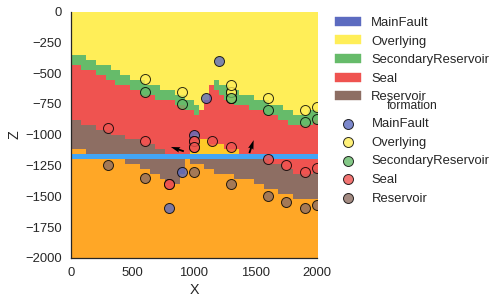

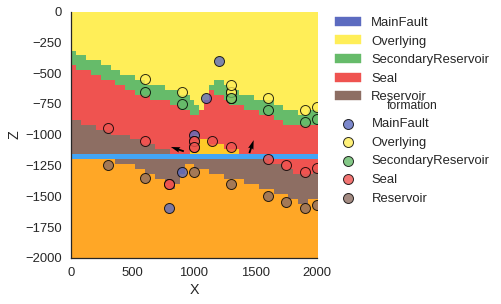

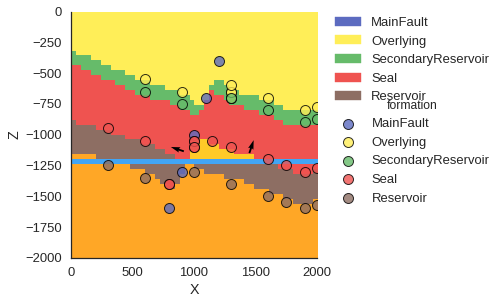

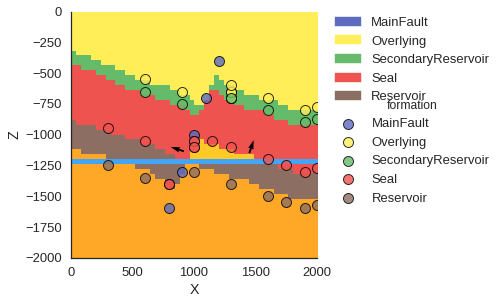

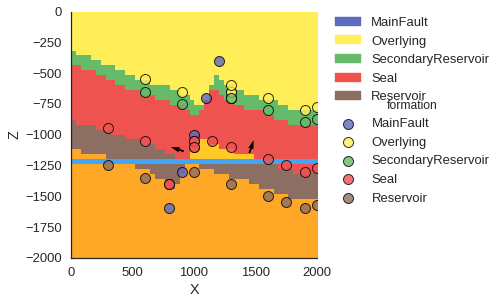

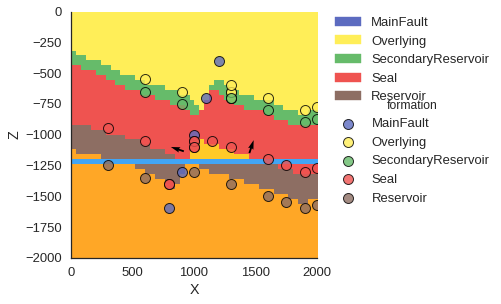

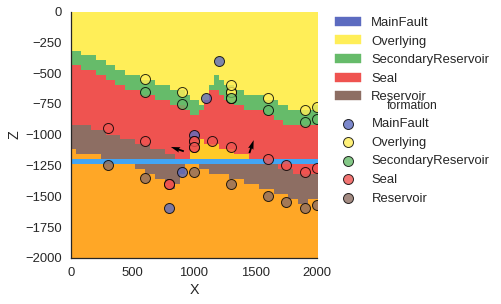

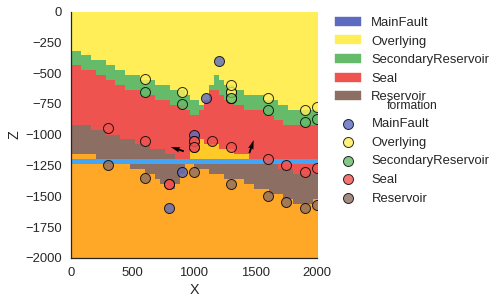

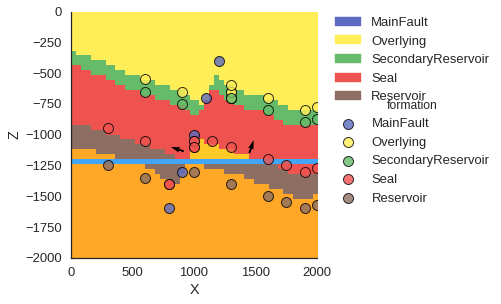

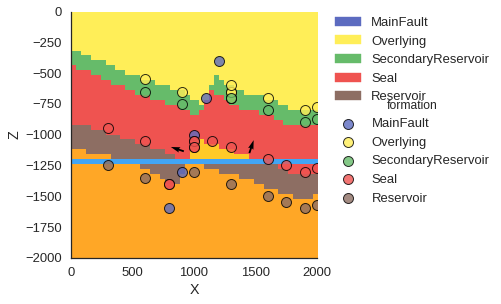

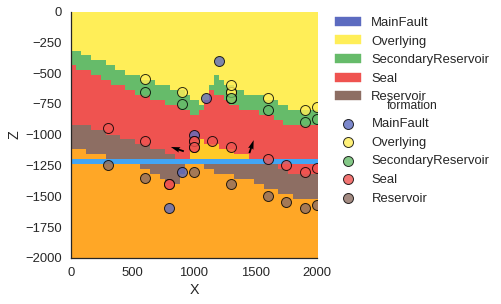

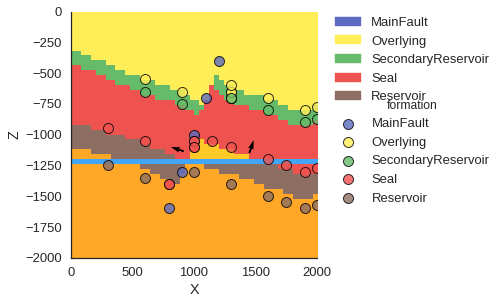

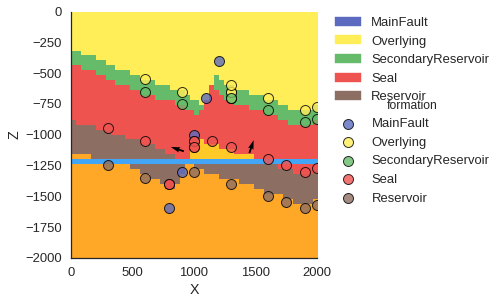

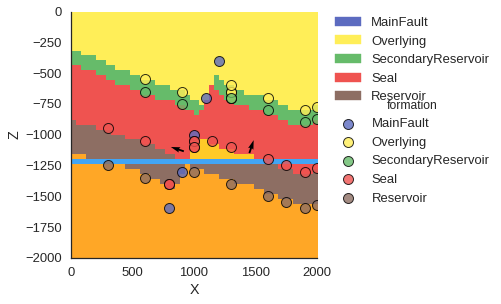

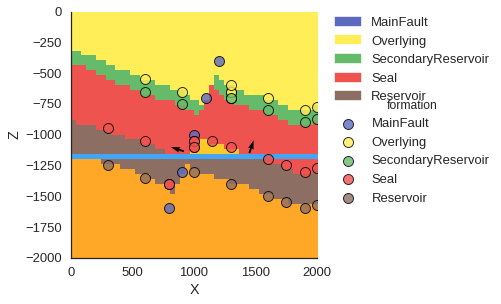

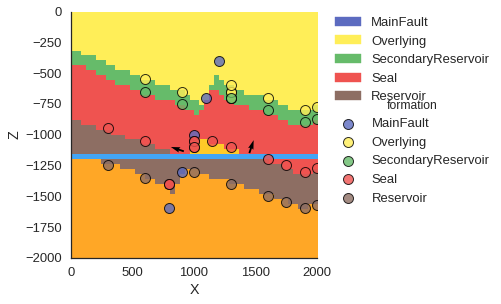

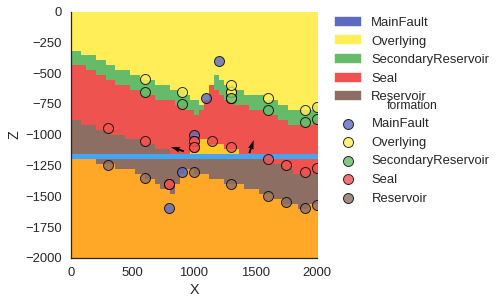

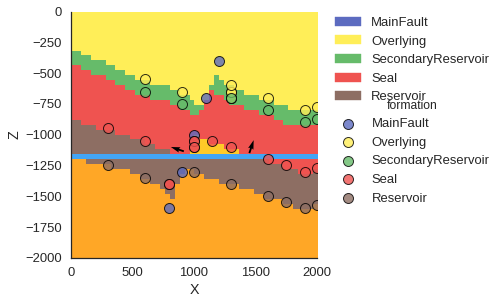

In [38]:
#model = pymc.Model([pos_unc_model, z_unc_res_top, fault_sealing, fw_th, hw_th, 
#                    res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])
model = pymc.Model([interp_unc, z_unc_res_top, fault_sealing, structural_model, 
                    res_th, seal_th, sec_res_th, 
                    res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])


M = pymc.MCMC(model)
M.sample(iter=iterations)

In [41]:
res_top_unc_trace = M.trace('z_unc_res_top')[:]
fault_sealing_trace = M.trace('fault_sealing_unc')[:]
structural_model_trace = M.trace('structural_model')[:] #[0]=lith_sol,[1]=fault:sol,[2]=max_volume

fw_res_th_trace = M.trace('res_th')[:]
fw_seal_th_trace = M.trace('seal_th')[:]
fw_sec_res_th_trace = M.trace('sec_res_th')[:]

interp_trace = M.trace('interp_unc')[:]

#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

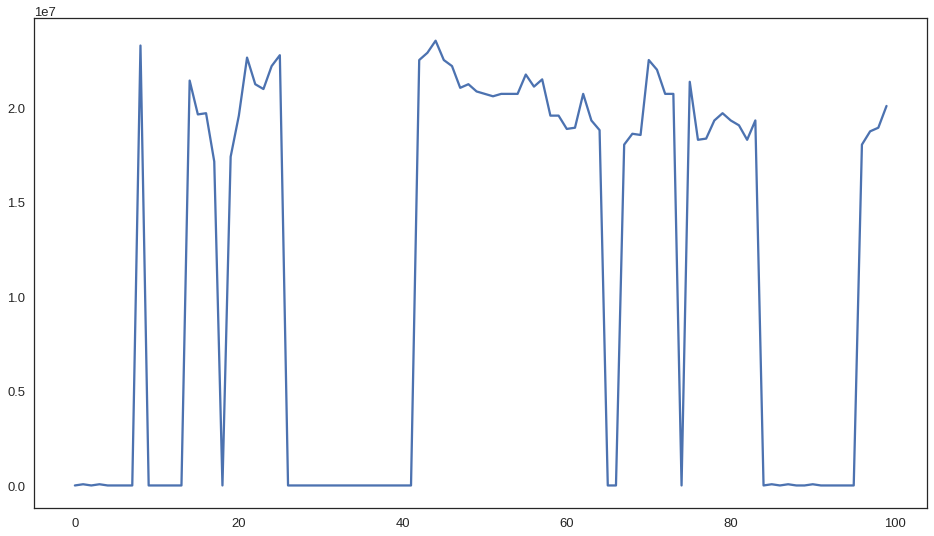

In [42]:
max_volume_trace = structural_model_trace[:,2]
plt.plot(max_volume_trace)

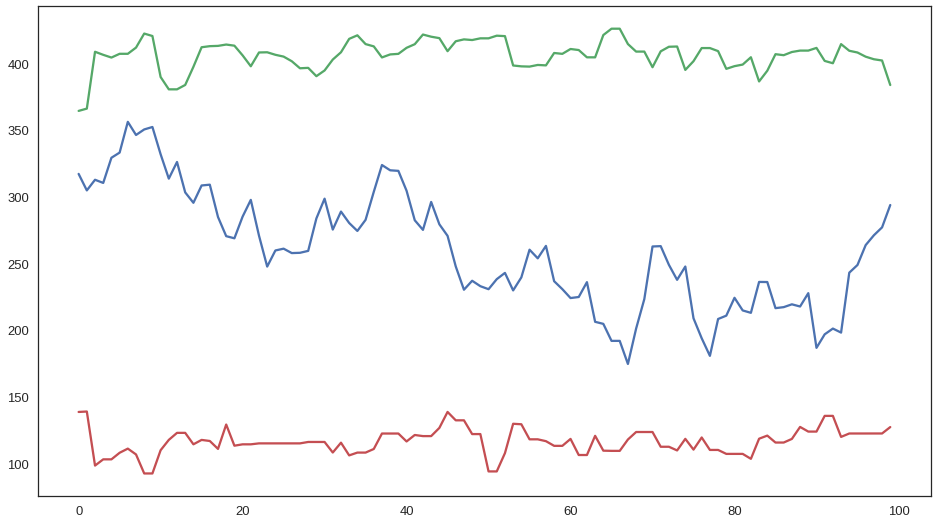

In [43]:
plt.plot(fw_res_th_trace)
plt.plot(fw_seal_th_trace)
plt.plot(fw_sec_res_th_trace)

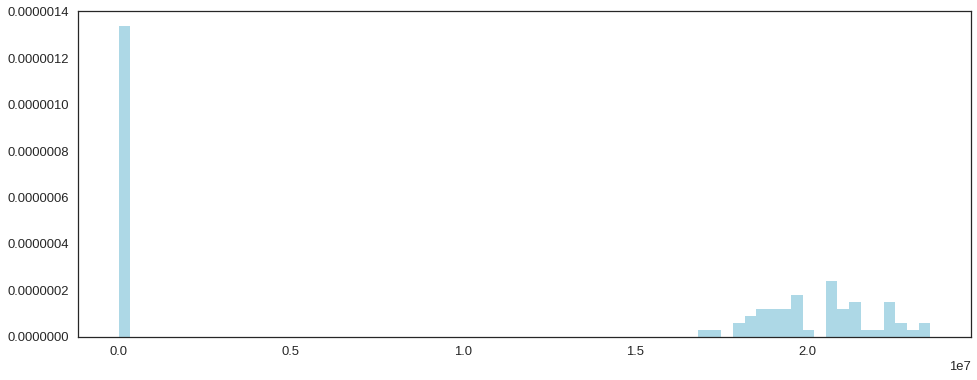

In [44]:
figsize(16, 6)

#_hist1 = plt.hist(max_volume_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")
volumes = max_volume_trace
mask = volumes == 0
masked_trace = volumes[~mask]
_hist1 = plt.hist(max_volume_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "lightblue")
#_hist1 = plt.hist(masked_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")

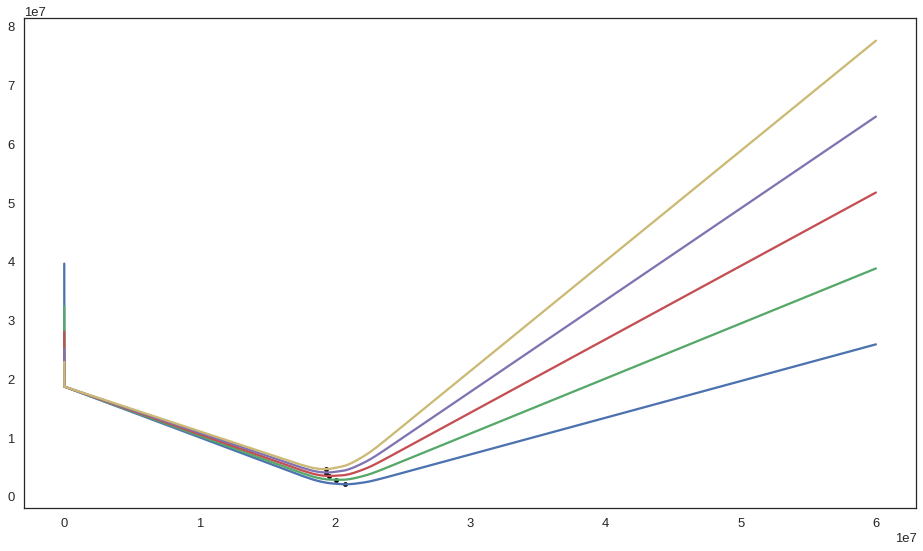

In [45]:
figsize(16, 9)

# No reduced uncertainty, different risks
BA_before = np.zeros_like(risks_s)
EL_before = np.zeros_like(risks_s)
expected_loss = lambda estimate_s, risk_s: volume_lossR(estimate_s, masked_trace, risk_s).mean()

counter = 0
for r in risks_s:
    loss = [expected_loss(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss, -40, args=(r,),disp = False)
    #print(_min_score)
    if _min_score < 0:
        _min_score = 0
    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
    plt.scatter(_min_score, expected_loss(_min_score,r), s = 20, color = 'black')
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_before[counter] = _min_score
    EL_before[counter] = expected_loss(_min_score,r)
    counter += 1


In [12]:
# DETERMINATION OF LAYER THICKNESSES ON HANGING- AND FOOTWALL BASED ON VOXEL-COUNTING
#fault_block = fault_sol[0,0]
#lith_block = lith_sol[0,0]
#th_factor = scale_factor
#
## Finding fault tips, upper and lower
#def find_fault_tips(fault_block):
#    fault_reshape = fault_block.reshape(50,50,50)
#    upper_fault_tip = np.count_nonzero(fault_reshape[:,25,49])+1
#    lower_fault_tip = np.count_nonzero(fault_reshape[:,25,0])-1
#    return upper_fault_tip, lower_fault_tip
#    
## Footwall thicknesses
#def fw_thicknesses(lith_block, upper_fault_tip, th_factor):
#    lith_reshape = lith_block.reshape(50,50,50)
#    fw_reservoir_count = 0
#    fw_seal_count = 0 
#    fw_sec_res_count = 0 
#    for i in lith_reshape[upper_fault_tip,25,:]:
#        if i == (interp_data.get_formation_number()['Reservoir']):
#            fw_reservoir_count += 1
#            fw_reservoir_thickness = fw_reservoir_count * th_factor
#        elif i == (interp_data.get_formation_number()['Seal']):
#            fw_seal_count += 1
#            fw_seal_thickness = fw_seal_count * th_factor
#        elif i == (interp_data.get_formation_number()['SecondaryReservoir']):
#            fw_sec_res_count += 1
#            fw_sec_res_thickness = fw_sec_res_count * th_factor
#    return fw_reservoir_thickness, fw_seal_thickness, fw_sec_res_thickness
#
## Hanging wall thicknesses
#def hw_thicknesses(lith_block, lower_fault_tip, th_factor):
#    hw_reservoir_count = 0
#    hw_seal_count = 0 
#    hw_sec_res_count = 0 
#    for i in lith_reshape[lower_fault_tip,25,:]:
#        if i == (interp_data.get_formation_number()['Reservoir']):
#            hw_reservoir_count += 1
#            hw_reservoir_thickness = hw_reservoir_count * th_factor
#        elif i == (interp_data.get_formation_number()['Seal']):
#            hw_seal_count += 1
#            hw_seal_thickness = hw_seal_count * th_factor
#        elif i == (interp_data.get_formation_number()['SecondaryReservoir']):
#            hw_sec_res_count += 1
#            hw_sec_res_thickness = hw_sec_res_count * th_factor
#    return hw_reservoir_thickness, hw_seal_thickness, hw_sec_res_thickness

# DETERMINING THICKNESS BASED ON Z-POINT_POSITIONS IN INTERP_DATA

# Footwall at X = 1600 and Y = 1000
#def fw_thicknesses(interp_data):
#    res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
#    seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
#    sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
#    over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'
#    
#    rescale_f = interp_data.rescaling_factor
#    
#    fw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (1400/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
#    points_fw = interp_data.geo_data_res.interfaces[fw_x_cond]
#    points_fw = points_fw[y_mid]
#    
#    fw_rb_z = points_fw[res_bot_cond]['Z'].values*rescale_f
#    fw_sb_z = points_fw[seal_bot_cond]['Z'].values*rescale_f
#    fw_r2b_z = points_fw[sec_res_bot_cond]['Z'].values*rescale_f
#    fw_ob_z = points_fw[over_bot_cond]['Z'].values*rescale_f
#    
#    fw_res_th = np.abs(fw_sb_z-fw_rb_z)
#    fw_seal_th = np.abs(fw_r2b_z-fw_sb_z)
#    fw_sec_res_th = np.abs(fw_ob_z-fw_r2b_z)
#    return fw_res_th, fw_seal_th, fw_sec_res_th, fw_rb_z, fw_sb_z, fw_r2b_z, fw_ob_z
#
## Hanging wall at X = 600 and Y = 1000
#def hw_thicknesses(interp_data):
#    res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
#    seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
#    sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
#    over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'
#    
#    rescale_f = interp_data.rescaling_factor
#    
#    hw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (400/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
#    points_hw = interp_data.geo_data_res.interfaces[hw_x_cond]
#    points_hw = points_hw[y_mid]
#    
#    hw_rb_z = points_hw[res_bot_cond]['Z']
#    hw_sb_z = points_hw[seal_bot_cond]['Z']
#    hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#    hw_ob_z = points_hw[over_bot_cond]['Z']
#    
#    hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)*rescale_f
#    hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)*rescale_f
#    hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)*rescale_f
#    return hw_res_th, hw_seal_th, hw_sec_res_th

# DETERMINING THICKNESS BASED ON Z-POINT_POSITIONS USING GEO_DATA
#res_bot_cond = geo_data.interfaces['formation'] == 'Reservoir'
#seal_bot_cond = geo_data.interfaces['formation'] == 'Seal'
#sec_res_bot_cond = geo_data.interfaces['formation'] == 'SecondaryReservoir'
#over_bot_cond = geo_data.interfaces['formation'] == 'Overlying'
#
#fw_x_cond = geo_data.interfaces['X'] == 1600
#y_mid = geo_data.interfaces['Y'] == 1000
#points_fw = geo_data.interfaces[fw_x_cond]
#points_fw = points_fw[y_mid]
## finding Z-values for each layer bottom
#fw_rb_z = points_fw[res_bot_cond]['Z']
#fw_sb_z = points_fw[seal_bot_cond]['Z']
#fw_r2b_z = points_fw[sec_res_bot_cond]['Z']
#fw_ob_z = points_fw[over_bot_cond]['Z']
#
#fw_res_th = np.abs(fw_sb_z.values-fw_rb_z.values)
#fw_seal_th = np.abs(fw_r2b_z.values-fw_sb_z.values)
#fw_sec_res_th = np.abs(fw_ob_z.values-fw_r2b_z.values)
#
#hw_x_cond = geo_data.interfaces['X'] == 600
#y_mid = geo_data.interfaces['Y'] == 1000
#points_hw = geo_data.interfaces[hw_x_cond]
#points_hw = points_hw[y_mid]
## finding Z-values for each layer bottom
#hw_rb_z = points_hw[res_bot_cond]['Z']
#hw_sb_z = points_hw[seal_bot_cond]['Z']
#hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#hw_ob_z = points_hw[over_bot_cond]['Z']
#
#hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)
#hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)
#hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)
#
## Footwall
#def fw_thicknesses():
#    fw_x_cond = geo_data.interfaces['X'] == 1600
#    y_mid = geo_data.interfaces['Y'] == 1000
#    points_fw = geo_data.interfaces[fw_x_cond]
#    points_fw = points_fw[y_mid]
#    # finding Z-values for each layer bottom
#    fw_rb_z = points_fw[res_bot_cond]['Z']
#    fw_sb_z = points_fw[seal_bot_cond]['Z']
#    fw_r2b_z = points_fw[sec_res_bot_cond]['Z']
#    fw_ob_z = points_fw[over_bot_cond]['Z']
#    
#    fw_res_th = np.abs(fw_sb_z.values-fw_rb_z.values)
#    fw_seal_th = np.abs(fw_r2b_z.values-fw_sb_z.values)
#    fw_sec_res_th = np.abs(fw_ob_z.values-fw_r2b_z.values)
#
## Hanging wall
#def hw_thicknesses():
#    hw_x_cond = geo_data.interfaces['X'] == 600
#    y_mid = geo_data.interfaces['Y'] == 1000
#    points_hw = geo_data.interfaces[hw_x_cond]
#    points_hw = points_hw[y_mid]
#    # finding Z-values for each layer bottom
#    hw_rb_z = points_hw[res_bot_cond]['Z']
#    hw_sb_z = points_hw[seal_bot_cond]['Z']
#    hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#    hw_ob_z = points_hw[over_bot_cond]['Z']
#    
#    hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)
#    hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)
#    hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)

In [206]:
#@pymc.deterministic
#def fault_tips(fault_sol=pos_unc_model[1]):
#    fault = fault_sol[0,0]
#    return find_fault_tips(fault)    
#
#@pymc.deterministic
#def fw_th(lith_sol=pos_unc_model[0], upper_fault_tip=fault_tips[0]):
#    lith = lith_sol[0,0]
#    #print("FOOTWALL RES THICKNESS:", fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)[0])
#    #print("FOOTWALL SEAL THICKNESS:", fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)[1])
#    return fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)
#
#@pymc.deterministic
#def hw_th(lith_sol=pos_unc_model[0], lower_fault_tip=fault_tips[1]):
#    lith = lith_sol[0,0]
#    return hw_thicknesses(lith, lower_fault_tip, th_factor=scale_factor)